In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39031")
client

<Client: 'tcp://127.0.0.1:39031' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import griddata
import gcm_filters
import gsw
import xrft
import s3fs
import os.path as op
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sdir = '/tank/spectre/tuchida/MLI/'
ddir = '/tank/spectre/tuchida/HYCOM50/'

<xarray.Dataset>
Dimensions:  (lat: 615, lon: 503)
Dimensions without coordinates: lat, lon
Data variables: (12/20)
    plat     (lat, lon) float64 ...
    plon     (lat, lon) float64 ...
    qlat     (lat, lon) float64 ...
    qlon     (lat, lon) float64 ...
    ulat     (lat, lon) float64 ...
    ulon     (lat, lon) float64 ...
    ...       ...
    vscx     (lat, lon) float64 ...
    vscy     (lat, lon) float64 ...
    pang     (lat, lon) float64 ...
    cori     (lat, lon) float64 ...
    pasp     (lat, lon) float64 ...
    depth    (lat, lon) float64 ...

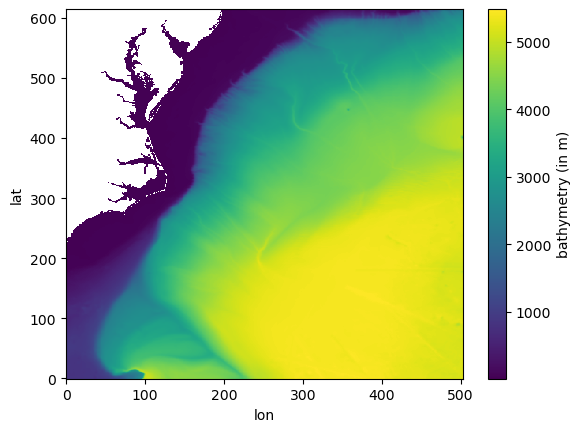

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()

# dsg = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()
dsg = xr.open_dataset(
    '/tank/spectre/tuchida/SWOT/Models/HYCOM50/HYCOM50_grid_GS_all.nc'
                     )
dsg.depth.plot(rasterized=True)
dsg

In [5]:
reg = '1_GS'
dss = cat.HYCOM50(region=reg,datatype='surf', season='fma'
                 ).to_dask().chunk({'lat':100,'lon':100})
dss.coords['day'] = ('time',np.repeat(np.arange(len(dss.time)//24),
                                      24))
dss = dss.groupby('day').mean('time',skipna=True)
dss = dss.rename({'day':'time'})
dss = dss.assign_coords({'lat':np.arange(len(dsg.lat)), 
                         'lon':np.arange(len(dsg.lon))})

taux = dss.tauewd
tauy = dss.taunwd
dss = dss.drop('tauewd')
dss = dss.drop('taunwd')
Ny = len(dsg.lat)
Nx = len(dsg.lon)

## Make metadata C-grid again ##

dss['taux'] = xr.DataArray(taux.data, dims=['time','lat','lonG'],
                           coords={'time':dss.time,
                                   'lat':dss.lat,'lonG':np.arange(-.5,Nx-.5,1)}
                          )
dss['tauy'] = xr.DataArray(tauy.data, dims=['time','latG','lon'],
                           coords={'time':dss.time,
                                   'latG':np.arange(-.5,Ny-.5,1),'lon':dss.lon}
                          )
dss

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:    (time: 90, lat: 615, lon: 503, lonG: 503, latG: 615)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * lat        (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lonG       (lonG) float64 -0.5 0.5 1.5 2.5 3.5 ... 498.5 499.5 500.5 501.5
  * latG       (latG) float64 -0.5 0.5 1.5 2.5 3.5 ... 610.5 611.5 612.5 613.5
Data variables:
    latitude   (time, lat) float32 dask.array<chunksize=(1, 100), meta=np.ndarray>
    longitude  (time, lon) float32 dask.array<chunksize=(1, 100), meta=np.ndarray>
    ssh        (time, lat, lon) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    sss        (time, lat, lon) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    uu1        (time, lat, lon) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    vv1        (time, lat, lon) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    taux       (time, lat, lonG) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    tauy       (time, latG, lon) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>

In [6]:
dsiw = cat.HYCOM50(region=reg, datatype='int_wvel', season='fma', decode_times=False
                  ).to_dask().chunk({'lat':100,'lon':100})
dsi = cat.HYCOM50(region=reg, datatype='int', season='fma', decode_times=False
                 ).to_dask().chunk({'lat':100,'lon':100})
dsiw = dsiw.rename({'lay':'layl'}).assign_coords({'layl':np.arange(-.5,31,1),
                                                  'lat':dss.lat, 'lon':dss.lon})
dsi = dsi.assign_coords({'lat':dss.lat, 'lon':dss.lon})

u3 = dsi.u3
v3 = dsi.v3
dsi = dsi.drop('u3')
dsi = dsi.drop('v3')

## Make metadata C-grid again ##

dsi['u3'] = xr.DataArray(u3.data, dims=['time','lay','lat','lonG'],
                         coords={'time':dsi.time,'lay':dsi.lay,
                                 'lat':dsi.lat,
                                 'lonG':dss.lonG
                                 # (dsi.lon.data
                                 #    - .5*np.concatenate((np.array([dsi.lon.diff('lon').data[0]]),
                                 #                                   dsi.lon.diff('lon').data))
                                 #        )
                                }
                        )
dsi['v3'] = xr.DataArray(v3.data, dims=['time','lay','latG','lon'],
                         coords={'time':dsi.time,'lay':dsi.lay,
                                 'latG':dss.latG,
                                 # (dsi.lat.data
                                 #   - .5*np.concatenate((np.array([dsi.lat.diff('lat').data[0]]),
                                 #                                   dsi.lat.diff('lat').data))
                                 #        ),
                                 'lon':dsi.lon}
                        )
dsi.coords['layl'] = np.arange(-.5,31,1)
dsi['w3'] = xr.DataArray(dsiw.wvel.data, dims=['time','layl','lat','lon'],
                         coords={'time':dsi.time,'layl':dsi.layl,
                                 'lat':dsi.lat,'lon':dsi.lon}
                        )
h3l = xr.DataArray(xr.concat([.5*dsi.h3.isel(lay=0), 
                              .5*(dsi.h3.isel(lay=slice(None,-1)).data
                                  + dsi.h3.isel(lay=slice(1,None)))
                             ], 'lay').transpose('time','lay','lat','lon').data,
                   dims=['time','layl','lat','lon'],
                   coords={'time':dsi.time,'layl':dsi.layl,
                           'lat':dsi.lat,'lon':dsi.lon}
                  )

Zl = h3l.cumsum('layl',skipna=True)
Zl = Zl.where(Zl>0.).load()
Z = dsi.h3.cumsum('lay',skipna=True)
Z = Z.where(Z>0.).load()

dsi['Z'] = Z
dsi['Zl'] = Zl

coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'}, 
        'Z':{'center':'lay', 'left':'layl'}
       }

grid = Grid(dsi, coords=coords, periodic=[])

dsi['Zu'] = grid.interp(Z, 'X', boundary='fill')
dsi['Zv'] = grid.interp(Z, 'Y', boundary='fill')

# xx, yy = np.meshgrid(dsg.longitude, dsg.latitude)
# dxT = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
#                    coords={'lat':dsi.lat,'lon':.5*(dsi.lon[1:].data+dsi.lon[:-1].data)}
#                   ).interp(lon=dsi.lon, method="linear",
#                            kwargs={"fill_value": "extrapolate"})
# dyT = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
#                    coords={'lat':.5*(dsi.lat[1:].data+dsi.lat[:-1].data),'lon':dsi.lon}
#                   ).interp(lat=dsi.lat, method="linear",
#                            kwargs={"fill_value": "extrapolate"})
dxT = xr.DataArray(dsg.pscx, dims=['lat','lon'],
                   coords={'lat':dsi.lat, 'lon':dsi.lon})
dyT = xr.DataArray(dsg.pscy, dims=['lat','lon'],
                   coords={'lat':dsi.lat, 'lon':dsi.lon})
# dxC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
#                                 coords={'lat':dsi.lat,
#                                         'lon':.5*(dsi.lon[1:].data+dsi.lon[:-1].data)}
#                                ).interp(lon=dsi.lonG, method="linear",
#                                         kwargs={"fill_value": "extrapolate"}),
#                    dims=['lat','lonG'],
#                    coords={'lat':dsi.lat,'lonG':dsi.lonG}
#                   )
# dyC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
#                                 coords={'lat':.5*(dsi.lat[1:].data+dsi.lat[:-1].data),
#                                         'lon':dsi.lon}
#                                ).interp(lat=dsi.latG, method="linear",
#                                         kwargs={"fill_value": "extrapolate"}),
#                    dims=['latG','lon'],
#                    coords={'latG':dsi.latG,'lon':dsi.lon}
#                   )
dxC = xr.DataArray(dsg.uscx, dims=['lat','lonG'],
                   coords={'lat':dsi.lat, 'lonG':np.arange(-.5,Nx-.5,1)})
dyC = xr.DataArray(dsg.vscy, dims=['latG','lon'],
                   coords={'latG':np.arange(-.5,Ny-.5,1), 'lon':dsi.lon})
# dxG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
#                                 coords={'lat':dsi.lat,
#                                         'lon':.5*(dsi.lon[1:].data+dsi.lon[:-1].data)}
#                                ).interp(lon=dsi.lon, method="linear",
#                                         kwargs={"fill_value": "extrapolate"}
#                                        ).interp(lat=dsi.latG, method='linear',
#                                                 kwargs={"fill_value": "extrapolate"}),
#                    dims=['latG','lon'],
#                    coords={'latG':dsi.latG,'lon':dsi.lon}
#                   )
# dyG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
#                                 coords={'lat':.5*(dsi.lat[1:].data+dsi.lat[:-1].data),
#                                         'lon':dsi.lon}
#                                ).interp(lat=dsi.lat, method="linear",
#                                         kwargs={"fill_value": "extrapolate"}
#                                        ).interp(lon=dsi.lonG, method='linear',
#                                                 kwargs={"fill_value": "extrapolate"}),
#                    dims=['lat','lonG'],
#                    coords={'lat':dsi.lat,'lonG':dsi.lonG}
#                   )
dyG = xr.DataArray(dsg.uscy, dims=['lat','lonG'],
                   coords={'lat':dsi.lat, 'lonG':np.arange(-.5,Nx-.5,1)})
dxG = xr.DataArray(dsg.vscx, dims=['latG','lon'],
                   coords={'latG':np.arange(-.5,Ny-.5,1), 'lon':dsi.lon})

dsi['dxT'] = dxT
dsi['dyT'] = dyT
dsi['dxC'] = dxC
dsi['dyC'] = dyC
dsi['dxG'] = dxG
dsi['dyG'] = dyG
dsi

<xarray.Dataset>
Dimensions:    (time: 90, lay: 32, lat: 615, lon: 503, lonG: 503, latG: 615,
                layl: 32)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * lat        (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lay        (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * lonG       (lonG) float64 -0.5 0.5 1.5 2.5 3.5 ... 498.5 499.5 500.5 501.5
  * latG       (latG) float64 -0.5 0.5 1.5 2.5 3.5 ... 610.5 611.5 612.5 613.5
  * layl       (layl) float64 -0.5 0.5 1.5 2.5 3.5 ... 26.5 27.5 28.5 29.5 30.5
Data variables: (12/19)
    h3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    latitude   (lat) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    layer      (lay) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    s3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    t3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    ...         ...
    dxT        (lat, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dyT        (lat, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dxC        (lat, lonG) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dyC        (latG, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dxG        (latG, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dyG        (lat, lonG) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03

In [7]:
def sig_hycom(s, t, nterm, pref):
    """
    hycom EOS output--sig2
    hycom EOS input == salinity/temperature/number of terms
    """

    if nterm==17:
#   -- 17/25 term
        c001= 9.9984085444849347E+02;    # num. constant    coefficent
        c002= 7.3471625860981584E+00;    # num.    T        coefficent
        c003=-5.3211231792841769E-02;    # num.    T^2      coefficent
        c004= 3.6492439109814549E-04;    # num.    T^3      coefficent
        c005= 2.5880571023991390E+00;    # num.       S     coefficent
        c006= 6.7168282786692355E-03;    # num.    T  S     coefficent
        c007= 1.9203202055760151E-03;    # num.       S^2   coefficent
        c008= 1.0000000000000000E+00;    # den. constant    coefficent
        c009= 7.2815210113327091E-03;    # den.    T        coefficent
        c010=-4.4787265461983921E-05;    # den.    T^2      coefficent
        c011= 3.3851002965802430E-07;    # den.    T^3      coefficent
        c012= 1.3651202389758572E-10;    # den.    T^4      coefficent
        c013= 1.7632126669040377E-03;    # den.       S     coefficent
        c014= 8.8066583251206474E-06;    # den.    T  S     coefficent
        c015= 1.8832689434804897E-10;    # den.    T^3S     coefficent
        c016= 5.7463776745432097E-06;    # den.    T  S^1.5 coefficent
        c017= 1.4716275472242334E-09;    # den.    T^3S^1.5 coefficent
#
        c018= 1.1798263740430364E-02;    # num. P           coefficent
        c019= 9.8920219266399117E-08;    # num. P  T^2      coefficent
        c020= 4.6996642771754730E-06;    # num. P     S     coefficent
        c021= 2.5862187075154352E-08;    # num. P^2         coefficent
        c022= 3.2921414007960662E-12;    # num. P^2T^2      coefficent
        c023= 6.7103246285651894E-06;    # den. P           coefficent
        c024= 2.4461698007024582E-17;    # den. P^2T^3      coefficent
        c025= 9.1534417604289062E-18;    # den. P^3T        coefficent

        prs2pdb=1.E-4    ;   #!Pascals to dbar
        pref=pref*1.E4   ;   #!ref. pressure in Pascals, sigma2 (default: 2000.)
        rpdb=pref*prs2pdb;   #!ref. pressure in dbar

        c101=c001+(c018-c021*rpdb)*rpdb; # num. constant    coefficent
        c103=c003+(c019-c022*rpdb)*rpdb; # num.    T^2      coefficent
        c105=c005+c020*rpdb;             # num.       S     coefficent
        c108=c008+c023*rpdb;             # den. constant    coefficent
        c109=c009-c025*rpdb**3;          # den.    T        coefficent
        c111=c011-c024*rpdb**2;          # den.    T^3      coefficent

        sig_n = c101 + (t*(c002+t*(c103+t*c004)) 
                        + s*(c105-t*c006+s*c007));
        sig_d = c108 + (t*(c109+t*(c010+t*(c111+t*c012))) 
                        + s*(c013-t*(c014+t*t*c015) 
                             + np.maximum(0,s)**0.5*(c016+t*t*c017)
                            )
                       )
        aout = sig_n/sig_d - 1000.0;
        
    elif nterm==9:
        c1= 9.903308E+00;                # const. coefficent
        c2=-1.618075E-02;                # T      coefficent
        c3= 7.819166E-01;                #    S   coefficent
        c4=-6.593939E-03;                # T^2    coefficent
        c5=-2.896464E-03;                # T  S   coefficent
        c6= 3.038697E-05;                # T^3    coefficent
        c7= 3.266933E-05;                # T^2S   coefficent
        c8= 1.180109E-04;                #    S^2 coefficent
        c9= 3.399511E-06;                # T  S^2 coefficent
        aout = c1+s*(c3+s* c8)+ t*(c2+s*(c5+s*c9)+t*(c4+s*c7+t*c6)) 
    else:
        print('Unknown nterm (either 9 or 17)')
    
    return aout

In [8]:
sig0 = xr.apply_ufunc(sig_hycom, dsi.s3.chunk({'time':1,'lat':100,'lon':100}), 
                      dsi.t3.chunk({'time':1,'lat':100,'lon':100}), 17, 0.,
                      dask='parallelized', output_dtypes=[float,]
)
sig0

<xarray.DataArray (time: 90, lay: 32, lat: 615, lon: 503)>
dask.array<transpose, shape=(90, 32, 615, 503), dtype=float64, chunksize=(1, 32, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lay      (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31

In [9]:
dsc = xr.open_zarr(op.join(ddir,'ATLc/topo/Coords.zarr')
                  )
ilim = np.array([[1000, 1502], [2200, 2702], [4800, 5302]])
jlim = np.array([[3030, 3644], [3030, 3644], [3357, 3878]])
dsc = dsc.rename({'YC':'lat', 'XC':'lon',
                  'YG':'latG','XG':'lonG'})
dsc_sub = dsc.isel(lat=slice(jlim[0,0],jlim[0,1]+1), 
                   lon=slice(ilim[0,0],ilim[0,1]+1))
dsc_sub = dsc_sub.assign_coords({'lat':dss.lat, 'lon':dss.lon})
dsc_sub

<xarray.Dataset>
Dimensions:  (lon: 503, lonG: 6709, lat: 615, latG: 7373)
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lonG     (lonG) float64 -98.7 -98.68 -98.66 -98.64 ... 38.91 38.93 38.95
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * latG     (latG) float64 -27.95 -27.93 -27.92 -27.9 ... 71.34 71.35 71.35
Data variables:
    tlat     (lat, lon) float64 dask.array<chunksize=(70, 40), meta=np.ndarray>
    tlon     (lat, lon) float64 dask.array<chunksize=(70, 40), meta=np.ndarray>
    ulon     (lat, lonG) float64 dask.array<chunksize=(70, 80), meta=np.ndarray>
    vlat     (latG, lon) float64 dask.array<chunksize=(100, 40), meta=np.ndarray>

In [10]:
for dd in range(32,122):
    if dd == 32:
        dsf = xr.open_dataset(op.join(ddir,'Surface/NEATL50_E030_Y019_D%03d_daymn.nc'
                                      % dd)
                             ).chunk({'j-index':100,'i-index':100})
    else:
        dsf = xr.concat([dsf,xr.open_dataset(op.join(ddir,
                                                'Surface/NEATL50_E030_Y019_D%03d_daymn.nc'
                                      % dd)
                             ).chunk({'j-index':100,'i-index':100})], 'time')
dsf = dsf.rename({'j-index':'lat','i-index':'lon'})
dsf_sub = dsf.isel(lat=slice(jlim[0,0],jlim[0,1]+1), 
                   lon=slice(ilim[0,0],ilim[0,1]+1))
dsf_sub = dsf_sub.assign_coords({'lat':dss.lat, 'lon':dss.lon, 'time':dss.time})
dsf_sub

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/tank/spectre/tuchida/envs/spec/lib/python3.9/si

<xarray.Dataset>
Dimensions:  (time: 90, lat: 615, lon: 503)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
Data variables:
    heatflx  (time, lat, lon) float32 dask.array<chunksize=(1, 70, 100), meta=np.ndarray>
    saltflx  (time, lat, lon) float32 dask.array<chunksize=(1, 70, 100), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 70, 100), meta=np.ndarray>
    sss      (time, lat, lon) float32 dask.array<chunksize=(1, 70, 100), meta=np.ndarray>

In [11]:
SA0 = xr.apply_ufunc(gsw.SA_from_SP, dss.sss, 0, dsc_sub.tlon, dsc_sub.tlat,
                     dask='parallelized')
CT0 = xr.apply_ufunc(gsw.CT_from_pt, SA0, dss.sst, dask='parallelized')
alpha = xr.apply_ufunc(gsw.alpha, SA0, CT0, 0, dask='parallelized')
# beta = xr.apply_ufunc(gsw.beta, SA, CT, 0, dask='parallelized')
alpha

<xarray.DataArray (time: 90, lat: 615, lon: 503)>
dask.array<transpose, shape=(90, 615, 503), dtype=float64, chunksize=(1, 70, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502

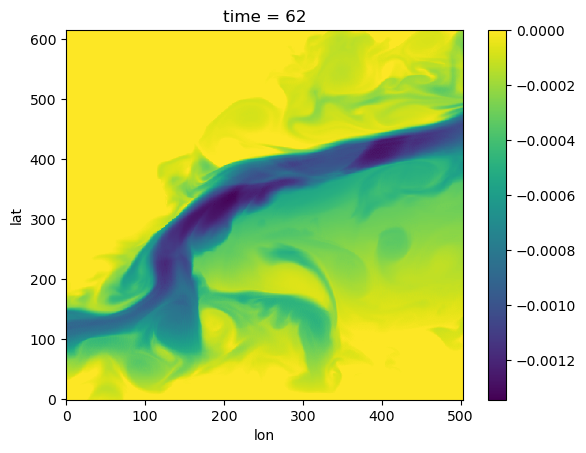

In [12]:
grav = 9.81
# Qs = g*(beta*1e3)*dsf_sub.saltflx # m/s2.(kg/s)/m2
Qt = dsf_sub.heatflx              # W/m2 = (kg.m2/s3)/m2
Cp = 1005.
rho_air = 1.225
B0 = grav*alpha * (Qt/rho_air/Cp)
B0 = B0.where(B0<0.).fillna(0.)
B0.isel(time=62).plot()

In [13]:
rho0 = 1000.
ustar = np.sqrt(np.sqrt(grid.interp(dss.taux**2,'X',boundary='extend') 
                        + grid.interp(dss.tauy**2,'Y',boundary='extend')
                       )
                / rho0)
ustar

<xarray.DataArray (time: 90, lat: 615, lon: 503)>
dask.array<sqrt, shape=(90, 615, 503), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


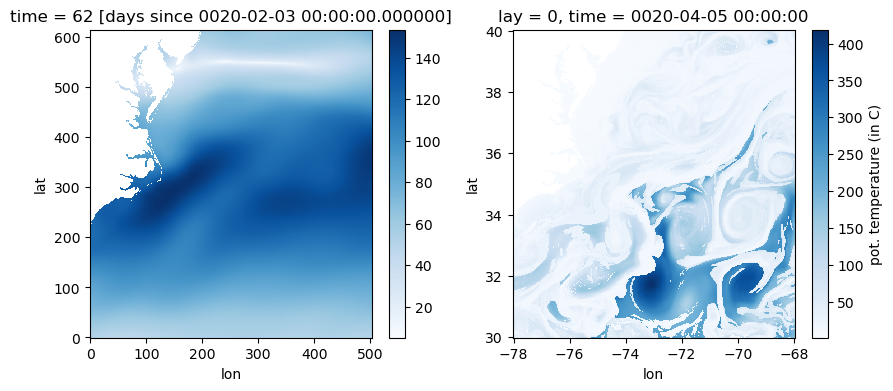

In [14]:
f = xr.apply_ufunc(gsw.f, dsc_sub.tlat,
                   dask='parallelized'
                  )
hEk = (.7*ustar / f)

H = xr.open_zarr(op.join(sdir,'HYCOM50/region%02d/MLD_fma.zarr'% 1)).H

fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
hEk.where(H.data>0.).isel(time=62).plot(ax=ax1, cmap='Blues')
H.where(H>0.).isel(time=62).plot(ax=ax2, cmap='Blues')

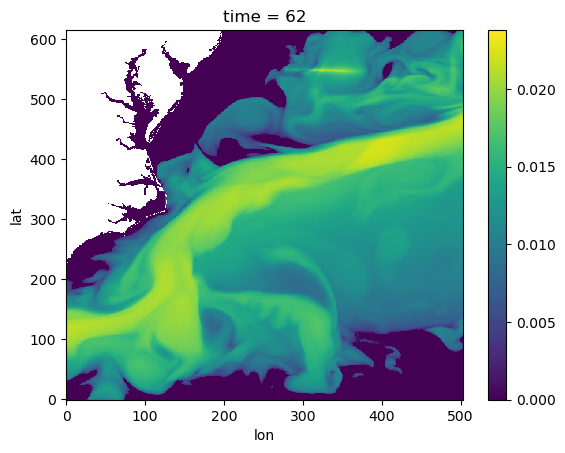

In [15]:
wstar = (-B0/hEk)**(1/3)
wstar.where(H.data>0.).isel(time=62).plot()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


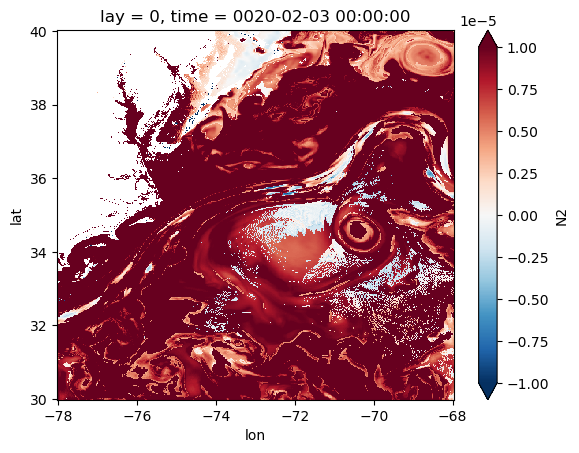

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


<xarray.DataArray 'N2' (time: 90, lat: 615, lon: 503)>
dask.array<setitem, shape=(90, 615, 503), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 29.99 30.01 30.02 30.04 ... 39.98 39.99 40.01 40.02
    lay      int64 0
  * lon      (lon) float64 -78.02 -78.0 -77.98 -77.96 ... -68.02 -68.0 -67.98
  * time     (time) object 0020-02-03 00:00:00 ... 0020-05-02 00:00:00

In [17]:
# pres = xr.apply_ufunc(gsw.p_from_z, -dsi.Z.chunk({'lay':4}), dsc_sub.tlat, 
#                       dask='parallelized')
# SA = xr.apply_ufunc(gsw.SA_from_SP, dsi.s3.chunk({'lay':4}), pres, 
#                     dsc_sub.tlon, dsc_sub.tlat,
#                     dask='parallelized')
# CT = xr.apply_ufunc(gsw.CT_from_pt, SA, dsi.t3.chunk({'lay':4}), dask='parallelized')

# for tt in range(len(dsi.time)):
#     n2, _ = gsw.Nsquared(grid.interp(SA.isel(time=tt),
#                                      'Z',boundary='fill'),
#                          grid.interp(CT.isel(time=tt),
#                                      'Z',boundary='fill'),
#                          pres.isel(time=tt),
#                          lat=dsc_sub.tlat, axis=0
#                         )
#     if tt == 0:
#         N2 = xr.DataArray(n2, 
#                           dims=dsi.t3.isel(time=tt,lay=slice(None,-1)).dims, 
#                           coords=dsi.t3.isel(time=tt,lay=slice(None,-1)).coords
#                          ).chunk({'lay':3,'lat':100,'lon':100})
#     else:
#         N2 = xr.concat([N2, 
#                         xr.DataArray(n2, 
#                                      dims=dsi.t3.isel(time=tt,lay=slice(None,-1)).dims, 
#                                      coords=dsi.t3.isel(time=tt,lay=slice(None,-1)).coords
#                                     ).chunk({'lay':3,'lat':100,'lon':100})
#                        ], 'time')
#     del n2
#     print(tt)
    
# N2.chunk({'time':1}).to_dataset(name='N2'
#                                ).to_zarr(op.join(sdir,'HYCOM50/region%02d/N2_filled_fma.zarr' 
#                                                  % int(reg[0])))
################
n2 = xr.open_zarr(op.join(sdir,'HYCOM50/region%02d/N2_fma.zarr' 
                          % int(reg[0]))
                 ).N2
# n2 = xr.open_zarr(op.join(sdir,'HYCOM50/region%02d/N2_filled_fma.zarr' 
#                           % int(reg[0]))
#                  ).N2
N2 = xr.ones_like(n2.isel(lay=0)) * np.nan
for tt in range(len(n2.time)):
    N2[dict(time=tt)] = ((n2.isel(time=tt) * dz.isel(time=tt).data
                         ).where(xr.DataArray(dsi.Z.isel(time=tt).data,
                                              dims=['lay','lat','lon'],
                                              coords={'lay':dsi.lay,
                                                      'lat':H.lat,
                                                      'lon':H.lon}
                                             )
                                 <= H.isel(time=tt)
                                ).sum('lay',skipna=True) 
          / H.isel(time=tt)).compute().chunk({'lat':100,'lon':100})
    if tt == 0:
        N2.isel(time=tt).plot(vmax=1e-5)
        plt.show()
    print(tt)
N2

In [18]:
Lf_old = np.sqrt(N2) * H / f.data

mstar = .5
nstar = .066
Lf_Ek = (mstar*ustar**3 + nstar*wstar**3)**(2/3) / f**2 / hEk
Lf_Ek

<xarray.DataArray (time: 90, lat: 615, lon: 503)>
dask.array<truediv, shape=(90, 615, 503), dtype=float64, chunksize=(1, 70, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502

Text(0.5, 1.0, '$L_f^{\\tt Ek}$')

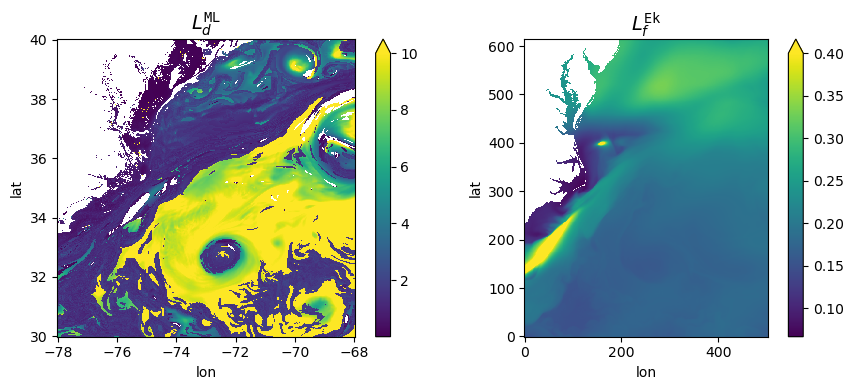

In [30]:
fig, (ax1,ax2) = plt.subplots(figsize=(9,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

(Lf_old.where(H.drop('time')>0.).isel(time=16)*1e-3).plot(ax=ax1, vmax=1e1, 
                                                          rasterized=True)
(Lf_Ek.where(H.drop('time').data>0.).isel(time=16)*1e-3).plot(ax=ax2, vmax=.4e0, 
                                                         rasterized=True)

ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax1.set_title(r"$L_d^{\tt ML}$", fontsize=14)
ax2.set_title(r"$L_f^{\tt Ek}$", fontsize=14)

In [19]:
zs = np.concatenate((np.linspace(3.1,35.97241992,10, endpoint=False), 
                     (1+np.tanh(np.linspace(-2,0,40)))*1e3))
zp1s = np.concatenate((np.array([1.55]),.5*(zs[1:] + zs[:-1])))
from scipy.interpolate import interp1d
ff = interp1d(np.arange(len(np.diff(zp1s))), np.abs(np.diff(zp1s)), 
             fill_value='extrapolate')
dzp1s = ff(np.arange(len(np.diff(zp1s))+1))

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


0


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


1


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


2


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


3


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


4


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


5


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


6


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


7


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


8


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


9


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


10


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


11


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


12


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


13


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


14


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


15


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


16


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


17


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


18


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


19


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


20


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


21


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


22


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


23


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


24


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


25


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


26


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


27


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


28


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


29


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


30


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


31


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


32


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


33


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


34


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


35


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


36


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


37


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


38


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


39


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


40


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


41


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


42


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


43


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


44


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


45


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


46


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


47


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


48


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


49


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


50


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


51


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


52


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


53


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


54


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


55


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


56


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


57


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


58


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


59


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


60


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


61


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


62


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


63


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


64


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


65


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


66


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


67


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


68


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


69


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


70


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


71


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


72


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


73


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


74


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


75


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


76


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


77


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


78


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


79


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


80


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


81


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


82


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


83


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


84


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


85


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


86


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


87


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


88


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


89


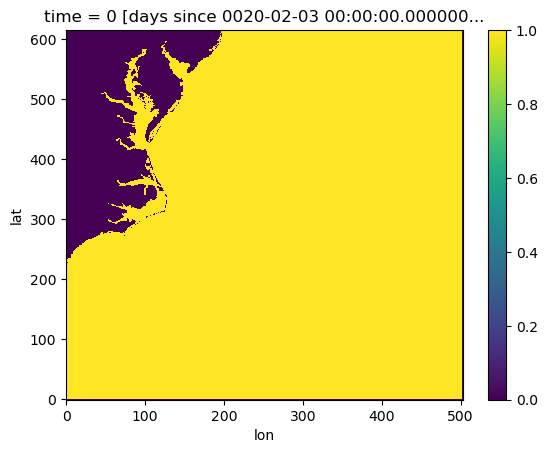

In [20]:
coords0={'X':{'center':'lon', 'left':'lonG'}, 
         'Y':{'center':'lat', 'left':'latG'}, 
         'Z':{'center':'lay', 'left':'layl'}
        }
grid0 = Grid(dsi.isel(time=0), coords=coords0, periodic=[])
wet_mask = xr.DataArray(np.zeros((len(dsi.time),len(zs),len(dsi.lat),len(dsi.lon))),
                        dims=['time','Z','lat','lon'],
                        coords={'time':dsi.time,'Z':zs,
                                'lat':dsi.lat,'lon':dsi.lon}
           ).chunk({'time':1,'Z':10,'lat':100,'lon':100})

for tt in range(len(dsi.time)):
    sw = grid0.transform(dsi.s3.isel(time=tt).chunk({'lay':-1}), 
                         'Z', zs, 
                         target_data=dsi.Z.isel(time=tt).chunk({'lay':-1})
                        ).chunk({'Z':10,'lat':100,'lon':100}
                               ).transpose('Z','lat','lon')
    wet_mask[tt,:,1:-1,1:-1] = (~np.ma.masked_invalid(sw).mask[...,1:-1,1:-1]
                               ).astype(np.float32)
    print(tt)
wet_mask.isel(time=0,Z=0).plot()

In [21]:
area = (dsi.dxT * dsi.dyT)

In [34]:
dxw = xr.DataArray(dsi.dxC.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dsi.dyG.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dsi.dxG.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dsi.dyC.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge

dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values

kappa_w = xr.ones_like(wet_mask.isel(time=0))
kappa_s = xr.ones_like(wet_mask.isel(time=0))

filter_scale = 30e3   # 30 km
filter_30km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'lat':-1,'lon':-1}), 
        'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
        'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
        'area': area.chunk({'lat':-1,'lon':-1}), 
        'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 
        'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
    }
)
filter_30km

Filter(filter_scale=30000.0, dx_min=array(1703.06066895), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=20, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [22]:
b = -grav*sig0 / rho0
bw = xr.DataArray(np.zeros((len(dsi.time),len(zs),
                            len(dsi.lat),len(dsi.lon))),
                  dims=['time','Z','lat','lon'],
                  coords={'time':dsi.time,'Z':zs,
                          'lat':dsi.lat,'lon':dsi.lon}
                 ).chunk({'time':1,'Z':10,'lat':100,'lon':100})
ww = bw.copy()
for tt in range(len(bw.time)):
    bw[dict(time=tt)] = grid.transform(b.isel(time=tt).chunk({'lay':-1}), 
                                       'Z', zs, 
                                       target_data=dsi.Z.isel(time=tt).chunk({'lay':-1})
                                      ).chunk({'Z':10,'lat':100,'lon':100}
                                             ).transpose('Z','lat','lon')
    ww[dict(time=tt)] = grid.transform(grid.interp(dsiw.wvel.isel(time=tt),
                                                   'Z',boundary='extend'
                                                  ).chunk({'lay':-1}), 
                                       'Z', zs, 
                                       target_data=dsi.Z.isel(time=tt).chunk({'lay':-1})
                                      ).chunk({'Z':10,'lat':100,'lon':100}
                                             ).transpose('Z','lat','lon')

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods w

In [36]:
wm = filter_30km.apply(ww.chunk({'lat':-1,'lon':-1}), 
                       dims=['lat', 'lon']
                      ).isel(lat=slice(1,-1),lon=slice(1,-1)
                            ).reset_coords(drop=True)
bm = filter_30km.apply(bw.chunk({'lat':-1,'lon':-1}), 
                       dims=['lat', 'lon']
                      ).isel(lat=slice(1,-1),lon=slice(1,-1)
                            ).reset_coords(drop=True)
dsave = wm.to_dataset(name='WVEL')
dsave['BUOY'] = bm
dsave.chunk({'time':1,'Z':10,'lat':100,'lon':100}
           ).to_zarr(op.join(sdir,'HYCOM50/region%02d/Meso_W-B.zarr' 
                             % int(reg[0])), mode='w')

In [24]:
dsm = xr.open_zarr(op.join(sdir,'HYCOM50/region%02d/Meso_W-B.zarr' 
                           % int(reg[0])))
dsm

<xarray.Dataset>
Dimensions:  (time: 90, Z: 50, lat: 613, lon: 501)
Coordinates:
  * Z        (Z) float64 3.1 6.387 9.674 12.96 16.25 ... 847.4 897.8 948.8 1e+03
  * lat      (lat) int64 1 2 3 4 5 6 7 8 9 ... 606 607 608 609 610 611 612 613
  * lon      (lon) int64 1 2 3 4 5 6 7 8 9 ... 494 495 496 497 498 499 500 501
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
Data variables:
    BUOY     (time, Z, lat, lon) float64 dask.array<chunksize=(1, 10, 100, 100), meta=np.ndarray>
    WVEL     (time, Z, lat, lon) float64 dask.array<chunksize=(1, 10, 100, 100), meta=np.ndarray>

In [23]:
dz = np.abs(grid.diff(dsi.Zl,'Z',boundary='extend')
           ).isel(lay=slice(None,-1))
dzz = bw.copy()
for tt in range(len(dz.time)):
    dzz[dict(time=tt)] = grid.transform(dz.isel(time=tt).chunk({'lay':-1}), 
                                       'Z', zs, 
                                       target_data=dsi.Z.isel(time=tt).chunk({'lay':-1})
                                      ).chunk({'Z':10,'lat':100,'lon':100}
                                             ).transpose('Z','lat','lon')

dzz

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods w

<xarray.DataArray (time: 90, Z: 50, lat: 615, lon: 503)>
dask.array<setitem, shape=(90, 50, 615, 503), dtype=float64, chunksize=(1, 10, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * Z        (Z) float64 3.1 6.387 9.674 12.96 16.25 ... 847.4 897.8 948.8 1e+03
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502

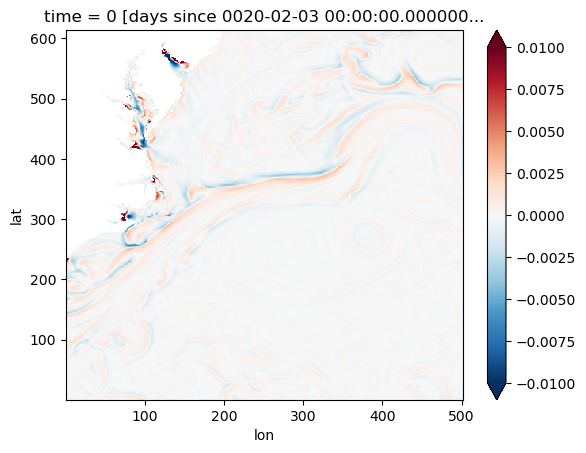

In [25]:
ws = (ww.isel(lat=slice(1,-1),lon=slice(1,-1)) 
      - dsm.WVEL)
bs = (bw.isel(lat=slice(1,-1),lon=slice(1,-1)) 
      - dsm.BUOY)
bs.isel(time=0,Z=0).plot(vmax=1e-2)

In [32]:
dswb = ws.to_dataset(name='ws')
dswb['bs'] = bs
dswb.coords['DXU'] = dsi.dxC.isel(lat=slice(1,-1),lonG=slice(1,-1))
dswb.coords['DYV'] = dsi.dyC.isel(latG=slice(1,-1),lon=slice(1,-1))
dswb.coords['DXT'] = dsi.dxT.isel(lat=slice(1,-1),lon=slice(1,-1))
dswb.coords['DYT'] = dsi.dyT.isel(lat=slice(1,-1),lon=slice(1,-1))

coords={
        "X": {"center": "lon", "left": "lonG"},
        "Y": {"center": "lat", "left": "latG"},
        # "Z": {"center": "Z",  "outer":"Zp1"}
       }
grids = Grid(dswb, periodic=[],
             coords=coords)

xT = grids.cumsum(dswb.DXU, 'X', boundary='extend')
yT = grids.cumsum(dswb.DYV, 'Y', boundary='extend')

ny, nx = xT.shape
xT = xT - xT.isel(lon=nx//2)
xT = (xT - xT.isel(lat=-1,lon=0)).values.flatten()
yT = (yT - yT.isel(lat=0)).values.flatten()

dx = dswb.DXT.min().values
dy = dswb.DYT.min().values

ws_terp = xr.DataArray(np.zeros_like(ws[::14,:].sel(Z=slice(None,100))), 
                       dims=ws.dims,
                       coords={'Z':ws.Z[:].sel(Z=slice(None,100)).data,
                               'lat':np.arange(0,ny*dy,dy),
                               'lon':np.arange(0,nx*dx,dx)}
                      )
bs_terp = xr.DataArray(np.zeros_like(bs[::14,:].sel(Z=slice(None,100))), 
                       dims=bs.dims,
                       coords={'Z':bs.Z[:].sel(Z=slice(None,100)).data,
                               'lat':np.arange(0,ny*dy,dy),
                               'lon':np.arange(0,nx*dx,dx)}
                      )

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]

for nn in range(len(dswb.time[::14])):
    for iz in range(len(ws_terp.Z)):
        ws_terp[dict(time=nn,Z=iz)
               ] = griddata((xT, yT), 
                            (ws[::14,:]
                             * area.isel(lat=slice(1,-1),lon=slice(1,-1))
                            ).isel(time=nn,Z=iz).values.flatten(),
                            (xxx, yyy) 
                           ).T
        bs_terp[dict(time=nn,Z=iz)
               ] = griddata((xT, yT), 
                            (bs[::14,:]
                             * area.isel(lat=slice(1,-1),lon=slice(1,-1))
                            ).isel(time=nn,Z=iz).values.flatten(),
                            (xxx, yyy) 
                           ).T
    print(nn)

ws_terp /= griddata((xT, yT), 
                    area.isel(lat=slice(1,-1),lon=slice(1,-1)
                             ).values.flatten(),
                    (xxx, yyy) 
                   ).T[np.newaxis,np.newaxis,:,:]
bs_terp /= griddata((xT, yT), 
                    area.isel(lat=slice(1,-1),lon=slice(1,-1)
                             ).values.flatten(),
                    (xxx, yyy) 
                   ).T[np.newaxis,np.newaxis,:,:]

dsave = ws_terp.to_dataset(name='Ws')
dsave['Bs'] = bs_terp
dsave.chunk({'time':1}).to_zarr(op.join(sdir,
                                'HYCOM50/region%02d/WsBs_interp.zarr' 
                                        % int(reg[0])),
                                mode='w')

0
1
2
3
4
5
6


In [33]:
dwsbs = xr.open_zarr(op.join(sdir,
                             'HYCOM50/region%02d/WsBs_interp.zarr' 
                             % int(reg[0]))
                    )
Cwsbs = xrft.isotropic_cross_spectrum(dwsbs.Ws.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.).chunk({'time':1}),
                                    dwsbs.Bs.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.).chunk({'time':1}),
                                    dim=['lat','lon'],
                                    # detrend='constant',
                                    window='hann', window_correction=True,
                                      nfactor=2,
                                    truncate=True
                                   )
Cwsbs

<xarray.DataArray (time: 7, Z: 21, freq_r: 93)>
dask.array<getitem, shape=(7, 21, 93), dtype=complex128, chunksize=(1, 21, 93), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float64 3.1 6.387 9.674 12.96 16.25 ... 72.38 79.89 88.14 97.2
  * freq_r   (freq_r) float64 2.005e-06 4.69e-06 ... 0.0002856 0.0002887
Dimensions without coordinates: time

In [34]:
CwsbsH = (Cwsbs * np.diff(zp1s)[np.newaxis,:len(Cwsbs.Z),np.newaxis]
         ).sum('Z',skipna=True) / 1e2
CwsbsH

<xarray.DataArray (time: 7, freq_r: 93)>
dask.array<truediv, shape=(7, 93), dtype=complex128, chunksize=(1, 93), chunktype=numpy.ndarray>
Coordinates:
  * freq_r   (freq_r) float64 2.005e-06 4.69e-06 ... 0.0002856 0.0002887
Dimensions without coordinates: time

In [35]:
nC = 12
laC = dsc_sub.lat.isel(lat=slice(1,-1)
                 ).coarsen({'lat':nC},boundary='trim'
                          ).mean(skipna=True)
loC = dsc_sub.lon.isel(lon=slice(1,-1)
                 ).coarsen({'lon':nC},boundary='trim'
                          ).mean(skipna=True)
aC = area.where(xr.DataArray(H.drop('time').data,
                             dims=['time','lat','lon'],
                             coords={'lat':area.lat,'lon':area.lon}
                            )>0.
               ).isel(lat=slice(1,-1),lon=slice(1,-1)
                     ).coarsen({'lat':nC,'lon':nC},boundary='trim'
                              ).sum(skipna=True)

In [45]:
dt = 1
for tt in np.arange(0,len(dsm.time),dt):
    # tend = i + dt
    # if tend > len(dsm.time)-1:
    #     tend = None
    if tt == 0:
        bmb = xr.DataArray(((dsm.BUOY.isel(time=tt)
                             * area.isel(lat=slice(1,-1),lon=slice(1,-1))
                    ).coarsen({'lat':nC,'lon':nC},boundary='trim').sum(skipna=True)
                    / aC.isel(time=tt)
                   ).data,
                   dims=['Z','lat','lon'], 
                   coords={'Z':zs,'lat':laC,'lon':loC}
        ).compute().chunk({'lat':-1,'lon':-1,'Z':3})
    else:
        bmb = xr.concat([bmb,
                         xr.DataArray(((dsm.BUOY.isel(time=tt)
                                        * area.isel(lat=slice(1,-1),lon=slice(1,-1))
                    ).coarsen({'lat':nC,'lon':nC},boundary='trim').sum(skipna=True)
                    / aC.isel(time=tt)
                   ).data,
                   dims=['Z','lat','lon'], 
                   coords={'Z':zs,'lat':laC,'lon':loC}
        ).compute().chunk({'lat':-1,'lon':-1,'Z':3})], 'time')
    print(tt)

bmb.to_dataset(name='BUOY').chunk({'time':1}
                                 ).to_zarr(op.join(sdir,
                                            'HYCOM50/region%02d/Coarse/nC%02d/Bm.zarr' 
                                                   % (int(reg[0]),nC)),
                                           mode='w')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [47]:
dt = 1
for tt in np.arange(0,len(dsm.time),dt):
    # tend = i + dt
    # if tend > len(dsm.time)-1:
    #     tend = None
    wsbs = (((ws * bs).isel(time=tt) * xr.DataArray(dzp1s, dims=['Z'])
            ).where(ws.Z <= xr.DataArray(H.data,
                             dims=['time','lat','lon'],
                             coords={'lat':area.lat,'lon':area.lon}
                            ).isel(time=tt,lat=slice(1,-1),lon=slice(1,-1))
                   ).sum('Z',skipna=True) 
            / xr.DataArray(H.data,
                           dims=['time','lat','lon'],
                           coords={'lat':area.lat,'lon':area.lon}
                          ).isel(time=tt,lat=slice(1,-1),lon=slice(1,-1))
           ).chunk({'lat':100,'lon':100})
    if tt == 0:
        wsbsb = xr.DataArray(((wsbs
                               * area.isel(lat=slice(1,-1),lon=slice(1,-1))
                              ).coarsen({'lat':nC,'lon':nC},boundary='trim'
                                       ).sum(skipna=True)
                              / aC.isel(time=tt)
                             ).data,
                             dims=['lat','lon'], 
                             coords={'lat':laC,'lon':loC}
                            ).compute()
    else:
        wsbsb = xr.concat([wsbsb, 
                           xr.DataArray(((wsbs
                               * area.isel(lat=slice(1,-1),lon=slice(1,-1))
                              ).coarsen({'lat':nC,'lon':nC},boundary='trim'
                                       ).sum(skipna=True)
                              / aC.isel(time=tt)
                             ).data,
                                        dims=['lat','lon'], 
                                        coords={'lat':laC,'lon':loC}
                                       ).compute()], 'time')
    del wsbs
    print(tt)

wsbsb.to_dataset(name='WsBs').chunk({'time':1}
                                   ).to_zarr(op.join(sdir,
                                    'HYCOM50/region%02d/Coarse/nC%02d/WsBsH.zarr' 
                                                     % (int(reg[0]),nC)),
                                             mode='w')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [36]:
dsC = xr.merge([xr.open_zarr(op.join(sdir,'HYCOM50/region%02d/Coarse/nC%02d/Bm.zarr' 
                                     % (int(reg[0]),nC))
                            ),
                xr.open_zarr(op.join(sdir,'HYCOM50/region%02d/Coarse/nC%02d/WsBsH.zarr' 
                                     % (int(reg[0]),nC))
                            )
               ])
dsC

<xarray.Dataset>
Dimensions:  (time: 90, Z: 50, lat: 51, lon: 41)
Coordinates:
  * Z        (Z) float64 3.1 6.387 9.674 12.96 16.25 ... 847.4 897.8 948.8 1e+03
  * lat      (lat) float64 6.5 18.5 30.5 42.5 54.5 ... 570.5 582.5 594.5 606.5
  * lon      (lon) float64 6.5 18.5 30.5 42.5 54.5 ... 450.5 462.5 474.5 486.5
Dimensions without coordinates: time
Data variables:
    BUOY     (time, Z, lat, lon) float64 dask.array<chunksize=(1, 3, 51, 41), meta=np.ndarray>
    WsBs     (time, lat, lon) float64 dask.array<chunksize=(1, 51, 41), meta=np.ndarray>

In [37]:
lonC = ((xr.DataArray(dsc_sub.tlon.data, dims=['lat','lon'],
                      coords={'lat':dss.lat,'lon':dss.lon}
                     ) * area
        ).isel(lat=slice(1,-1),lon=slice(1,-1)
              ).coarsen({'lat':nC,'lon':nC},boundary='trim').sum(skipna=True)
        / area.isel(lat=slice(1,-1),lon=slice(1,-1)
                   ).coarsen({'lat':nC,'lon':nC},boundary='trim').sum(skipna=True)
       )
latC = ((xr.DataArray(dsc_sub.tlat.data, dims=['lat','lon'],
                      coords={'lat':dss.lat,'lon':dss.lon}
                     ) * area
        ).isel(lat=slice(1,-1),lon=slice(1,-1)
              ).coarsen({'lat':nC,'lon':nC},boundary='trim').sum(skipna=True)
        / area.isel(lat=slice(1,-1),lon=slice(1,-1)
                   ).coarsen({'lat':nC,'lon':nC},boundary='trim').sum(skipna=True)
       )
yC = dsi.lat.isel(lat=slice(1,-1)).coarsen({'lat':nC},boundary='trim').mean(skipna=True)
xC = dsi.lon.isel(lon=slice(1,-1)).coarsen({'lon':nC},boundary='trim').mean(skipna=True)
yG = dsi.latG.isel(latG=slice(1,-1)).coarsen({'latG':nC},boundary='trim').mean(skipna=True)
xG = dsi.lonG.isel(lonG=slice(1,-1)).coarsen({'lonG':nC},boundary='trim').mean(skipna=True)
dsC['fb'] = xr.DataArray(xr.apply_ufunc(gsw.f, latC,
                                 dask='parallelized'
                                ).data, 
                  dims=['lat','lon'],
                  coords={'lat':yC,'lon':xC}
                 )
dsC.coords['DXU'] = xr.DataArray(dsi.dxC.isel(lonG=slice(1,-1)
                                             ).coarsen({'lonG':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(lat=slice(1,-1)
                                             ).coarsen({'lat':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['lat','lonG'], 
                   coords={'lat':yC,'lonG':xG}
                  )
dsC.coords['DYU'] = xr.DataArray(dsi.dyG.isel(lat=slice(1,-1)
                                             ).coarsen({'lat':nC,},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(lonG=slice(1,-1)
                                             ).coarsen({'lonG':nC,},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['lat','lonG'], 
                   coords={'lat':yC,'lonG':xG}
                  )
dsC.coords['DXV'] = xr.DataArray(dsi.dxG.isel(lon=slice(1,-1)
                                             ).coarsen({'lon':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(latG=slice(1,-1)
                                             ).coarsen({'latG':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['latG','lon'], 
                   coords={'latG':yG,'lon':xC}
                  )
dsC.coords['DYV'] = xr.DataArray(dsi.dyC.isel(latG=slice(1,-1)
                                             ).coarsen({'latG':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(lon=slice(1,-1)
                                             ).coarsen({'lon':nC},
                                   boundary='trim').mean(skipna=True),
                   dims=['latG','lon'], 
                   coords={'latG':yG,'lon':xC}
                  )
dsC.coords['DXT'] = xr.DataArray(dsi.dxT.isel(lon=slice(1,-1)
                                             ).coarsen({'lon':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(lat=slice(1,-1)
                                             ).coarsen({'lat':nC},
                                   boundary='trim').mean(skipna=True
                                                       ),
                   dims=['lat','lon'], 
                   coords={'lat':yC,'lon':xC}
                  )
dsC.coords['DYT'] = xr.DataArray(dsi.dyT.isel(lat=slice(1,-1)
                                             ).coarsen({'lat':nC},
                                   boundary='trim').sum(skipna=True
                                                       ).isel(lon=slice(1,-1)
                                             ).coarsen({'lon':nC},
                                   boundary='trim').mean(skipna=True),
                   dims=['lat','lon'], 
                   coords={'lat':yC,'lon':xC}
                  )
dsC

<xarray.Dataset>
Dimensions:  (time: 90, Z: 50, lat: 51, lon: 41, lonG: 41, latG: 51)
Coordinates:
  * Z        (Z) float64 3.1 6.387 9.674 12.96 16.25 ... 847.4 897.8 948.8 1e+03
  * lat      (lat) float64 6.5 18.5 30.5 42.5 54.5 ... 570.5 582.5 594.5 606.5
  * lon      (lon) float64 6.5 18.5 30.5 42.5 54.5 ... 450.5 462.5 474.5 486.5
  * lonG     (lonG) float64 6.0 18.0 30.0 42.0 54.0 ... 450.0 462.0 474.0 486.0
    DXU      (lat, lonG) float64 2.309e+04 2.309e+04 ... 2.047e+04 2.047e+04
    DYU      (lat, lonG) float64 2.309e+04 2.309e+04 ... 2.047e+04 2.047e+04
  * latG     (latG) float64 6.0 18.0 30.0 42.0 54.0 ... 570.0 582.0 594.0 606.0
    DXV      (latG, lon) float64 2.309e+04 2.309e+04 ... 2.047e+04 2.047e+04
    DYV      (latG, lon) float64 2.309e+04 2.309e+04 ... 2.047e+04 2.047e+04
    DXT      (lat, lon) float64 2.309e+04 2.309e+04 ... 2.047e+04 2.047e+04
    DYT      (lat, lon) float64 2.309e+04 2.309e+04 ... 2.047e+04 2.047e+04
Dimensions without coordinates: time
Data variables:
    BUOY     (time, Z, lat, lon) float64 dask.array<chunksize=(1, 3, 51, 41), meta=np.ndarray>
    WsBs     (time, lat, lon) float64 dask.array<chunksize=(1, 51, 41), meta=np.ndarray>
    fb       (lat, lon) float64 dask.array<chunksize=(5, 3), meta=np.ndarray>

In [38]:
coords={
        "X": {"center": "lon", "left": "lonG"},
        "Y": {"center": "lat", "left": "latG"},
        # "Z": {"center": "Z",  "outer":"Zp1"}
       }
gridC = Grid(dsC, periodic=[],
             coords=coords)

In [39]:
Hb = xr.DataArray((xr.DataArray(H.drop('time').data,
                                dims=['time','lat','lon'],
                                coords={'time':H.time,'lat':area.lat,
                                        'lon':area.lon}
                               ) * area
                  ).where(xr.DataArray(H.drop('time').data,
                                       dims=['time','lat','lon'],
                                       coords={'time':H.time,'lat':area.lat,
                                               'lon':area.lon}
                                      ) > 0.
                         ).isel(lat=slice(1,-1),lon=slice(1,-1)
                                             ).coarsen({'lat':nC,'lon':nC},
                                                       boundary='trim'
                                                      ).sum(skipna=True)
      / aC,
                  dims=['time','lat','lon'], 
                  coords={'lat':yC,'lon':xC}
     ).chunk({'lat':-1,'lon':-1})
Lf_oldb = xr.DataArray((xr.DataArray(Lf_old.drop('time').data,
                                     dims=['time','lat','lon'],
                                     coords={'time':H.time,'lat':area.lat,
                                             'lon':area.lon}
                                    )
                        * area).isel(lat=slice(1,-1),lon=slice(1,-1)
                                    ).coarsen({'lat':nC,'lon':nC},boundary='trim'
                                             ).sum(skipna=True)
      / aC,
                  dims=['time','lat','lon'], 
                  coords={'lat':yC,'lon':xC}
     ).chunk({'lat':-1,'lon':-1})
Lf_oldb = Lf_oldb.where(Lf_oldb>0.)
Lf_Ekb = xr.DataArray((Lf_Ek.where(xr.DataArray(H.drop('time').data,
                                                dims=['time','lat','lon'],
                                                coords={'lat':area.lat,
                                                        'lon':area.lon}
                                               ) > 0.)
                       * area).isel(lat=slice(1,-1),lon=slice(1,-1)
                            ).coarsen({'lat':nC,'lon':nC},boundary='trim').sum(skipna=True)
      / aC,
                  dims=['time','lat','lon'], 
                  coords={'lat':yC,'lon':xC}
     ).chunk({'lat':-1,'lon':-1})
# Lf_Eblb = xr.DataArray((Lf_Ebl*area).where(ds.maskC.isel(Z=0)!=0.
#                                         ).isel(YC=slice(1,-1),XC=slice(1,-1)
#                             ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
#       / aC.isel(Z=0),
#                   dims=['time','YC','XC'], 
#                   coords={'time':ds.time,'YC':yC,'XC':xC}
#      ).chunk({'YC':-1,'XC':-1})
Db = xr.DataArray((dsg.depth
                   * area).isel(lat=slice(1,-1),lon=slice(1,-1)
                               ).coarsen({'lat':nC,'lon':nC},boundary='trim'
                                                     ).sum(skipna=True)
      / area.isel(lat=slice(1,-1),lon=slice(1,-1)
                 ).coarsen({'lat':nC,'lon':nC},boundary='trim').sum(skipna=True),
                  dims=['lat','lon'], 
                  coords={'lat':yC,'XC':xC}
     ).chunk({'lat':-1,'lon':-1})

B_x = ((gridC.interp(gridC.diff(dsC.BUOY,'X',boundary='extend') 
                     / dsC.DXU,
                     'X',boundary='extend')
        * xr.DataArray(dzp1s, dims=['Z'])
       ).where(dsC.Z<=Hb).sum('Z',skipna=True
                             ).reset_coords(drop=True).chunk({'lat':-1,'lon':-1})
       / Hb)
B_y = ((gridC.interp(gridC.diff(dsC.BUOY,'Y',boundary='extend') 
                     / dsC.DYV,
                     'Y',boundary='extend')
        * xr.DataArray(dzp1s, dims=['Z'])
       ).where(dsC.Z<=Hb).sum('Z',skipna=True
                             ).reset_coords(drop=True).chunk({'lat':-1,'lon':-1}) 
       / Hb)

Text(0.5, 1.0, '$L_f^{\\tt Ek}$')

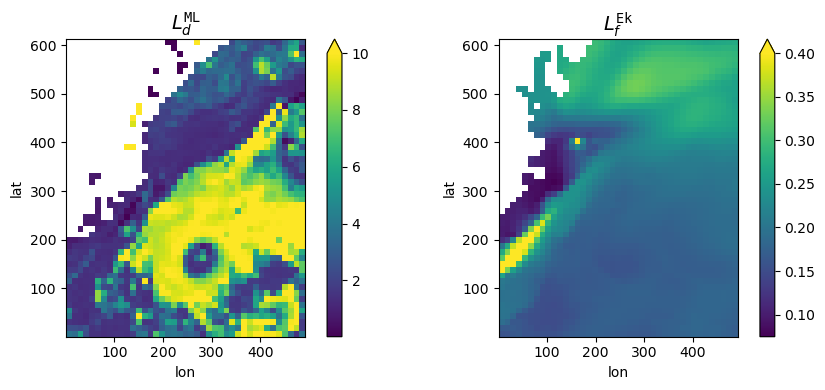

In [55]:
fig, (ax1,ax2) = plt.subplots(figsize=(9,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

(Lf_oldb.isel(time=16)*1e-3).plot(ax=ax1, vmax=1e1, rasterized=True)
(Lf_Ekb.isel(time=16)*1e-3).plot(ax=ax2, vmax=.4e0, rasterized=True)

ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax1.set_title(r"$L_d^{\tt ML}$", fontsize=14)
ax2.set_title(r"$L_f^{\tt Ek}$", fontsize=14)

In [40]:
Psix_old = np.sqrt(aC)/Lf_oldb/dsC.fb * Hb**2 * B_y
Psiy_old = np.sqrt(aC)/Lf_oldb/dsC.fb * Hb**2 * (-B_x)
Psix_Ek  = np.sqrt(aC)/Lf_Ekb/dsC.fb * Hb**2 * B_y
Psiy_Ek  = np.sqrt(aC)/Lf_Ekb/dsC.fb * Hb**2 * (-B_x)
Psix_Ek

<xarray.DataArray (lat: 51, lon: 41, time: 90)>
dask.array<mul, shape=(51, 41, 90), dtype=float64, chunksize=(6, 7, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6.5 18.5 30.5 42.5 54.5 ... 570.5 582.5 594.5 606.5
  * lon      (lon) float64 6.5 18.5 30.5 42.5 54.5 ... 450.5 462.5 474.5 486.5
    DXT      (lat, lon) float64 2.309e+04 2.309e+04 ... 2.047e+04 2.047e+04
    DYT      (lat, lon) float64 2.309e+04 2.309e+04 ... 2.047e+04 2.047e+04
Dimensions without coordinates: time

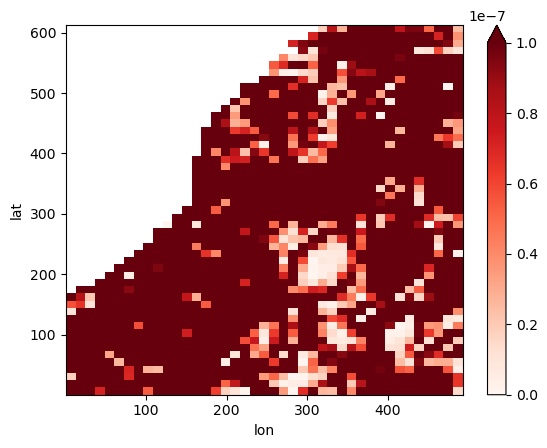

In [41]:
bff   = (Psix_old*B_y - Psiy_old*B_x)
bodEk = (Psix_Ek*B_y  - Psiy_Ek*B_x )
maskbff = xr.DataArray(np.ma.masked_invalid(bff).mask,
                       dims=bff.dims, coords=bff.coords
                      ).chunk(bff.chunks)
bff = bff.where(maskbff!=1.)
maskbod = xr.DataArray(np.ma.masked_invalid(bodEk).mask,
                       dims=bodEk.dims, coords=bodEk.coords
                      ).chunk(bodEk.chunks)
bodEk = bodEk.where(maskbod!=1.)
bff.where(Db>2e2).isel(time=62).plot(cmap='Reds', vmax=1e-7)

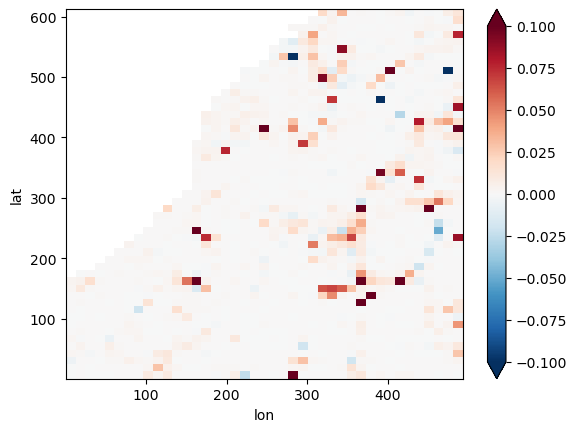

In [42]:
Ce   = (dsC.WsBs / bff  ).where(Db>2e2).reset_coords(drop=True)
CrEk = (dsC.WsBs / bodEk).where(Db>2e2).reset_coords(drop=True)
CrEk.isel(time=62).plot(vmax=1e-1)

In [43]:
CeC   = Ce.median(['lat','lon'],skipna=True).compute()
CrEkC = CrEk.median(['lat','lon'],skipna=True).compute()

In [33]:
CeC.mean('time'), CrEkC.mean('time')

(<xarray.DataArray ()>
 array(0.00596264),
 <xarray.DataArray ()>
 array(0.00033599))

In [44]:
time = np.arange('2012-02-01', '2012-05-01', 
                 dtype='datetime64[D]')

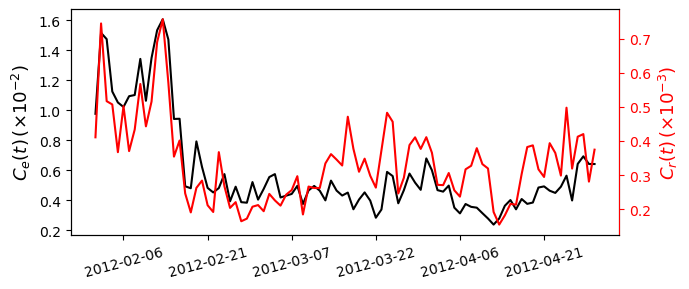

In [94]:
fig, ax = plt.subplots(figsize=(7,3))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(range(90), CeC.values*1e2, 'k', label=r"$C_e(t)$")
ax2.plot(range(90), CrEkC.values*1e3, 'r', label=r"$C_r(t)$")
# ax2.plot(range(90), CrEblC.values, 'm--', label=r"$h=h_{ePBL}$")

ax.set_xticks(np.arange(90)[5::15])
ax.set_xticklabels(time[5::15], rotation=15)
ax2.yaxis.label.set_color('red')         #setting up Y-axis label color to blue
ax2.tick_params(axis='y', colors='red')  #setting up Y-axis tick color to black
ax2.spines['right'].set_color('red')
# ax.legend(loc='lower left', fontsize=12)
# ax2.legend(loc='upper right', fontsize=12)
ax.set_ylabel(r"$C_e(t)\,(\times 10^{-2})$", fontsize=13)
ax2.set_ylabel(r"$C_r(t)\,(\times 10^{-3})$", fontsize=13)
plt.savefig(op.join(sdir,'Figs/HYCOM50_region%02d_nC%02d_Cs.pdf' 
                    % (int(reg[0]),nC)))

In [45]:
cbodEk = (bodEk*CrEkC).where(Db>2e2).reset_coords(drop=True)
cbff = (bff*CeC).where(Db>2e2).reset_coords(drop=True)
CbodEk = (bodEk*CrEkC.mean('time')).where(Db>2e2).reset_coords(drop=True)
Cbff = (bff*CeC.mean('time')).where(Db>2e2).reset_coords(drop=True)
WsBs = dsC.WsBs.where(Db>2e2).reset_coords(drop=True)
cbodEk.name = 'Ekman'
cbff.name = 'BFF'
CbodEk.name = 'Ekman'
Cbff.name = 'BFF'
WsBs.name = 'Submeso'

In [46]:
xT = gridC.cumsum(dsC.DXU, 'X', boundary='extend')
yT = gridC.cumsum(dsC.DYV, 'Y', boundary='extend')

ny, nx = xT.shape
xT = xT - xT.isel(lon=nx//2)
xT = (xT - xT.isel(lat=-1,lon=0)).values.flatten()
yT = (yT - yT.isel(lat=0)).values.flatten()

dx = dsC.DXT.min().values
dy = dsC.DYT.min().values

In [47]:
Ekterp = xr.DataArray(np.zeros_like(cbodEk[...,::14]), dims=cbodEk.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )
bfterp = xr.DataArray(np.zeros_like(cbff[...,::14]), dims=cbff.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )
wbterp = xr.DataArray(np.zeros_like(WsBs[::14]), dims=WsBs.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )
Aterp = xr.DataArray(np.zeros_like(aC[...,::14]), dims=aC.dims,
                     coords={'lat':np.arange(0,ny*dy,dy),
                             'lon':np.arange(0,nx*dx,dx)}
                    )

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]
for nn in range(len(WsBs.time[::14])):

    Ekterp[dict(time=nn)] = griddata((xT, yT), 
                                     (cbodEk*aC
                                     )[...,::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    bfterp[dict(time=nn)] = griddata((xT, yT), 
                                     (cbff*aC
                                     )[...,::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T
    wbterp[dict(time=nn)] = griddata((xT, yT), 
                                     (WsBs*aC
                                     )[::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T
    Aterp[dict(time=nn)] = griddata((xT, yT), 
                                    aC[...,::14].isel(time=nn).values.flatten(),
                                    (xxx, yyy) 
                                   ).T
Ekterp /= Aterp
bfterp /= Aterp
wbterp /= Aterp

In [48]:
Bx_terp = xr.DataArray(np.zeros_like(B_x[::14]), dims=B_x.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )
By_terp = xr.DataArray(np.zeros_like(B_y[::14]), dims=B_y.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]

for nn in range(len(WsBs.time[::14])):
    Bx_terp[dict(time=nn)] = griddata((xT, yT), 
                                     (B_x*aC
                                     )[::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    By_terp[dict(time=nn)] = griddata((xT, yT), 
                                     (B_y*aC
                                     )[::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T
    
Bx_terp /= Aterp
By_terp /= Aterp

In [49]:
Psix_bfterp = xr.DataArray(np.zeros_like(Psix_old[...,::14]), 
                           dims=Psix_old.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )
Psiy_bfterp = xr.DataArray(np.zeros_like(Psiy_old[...,::14]), 
                           dims=Psiy_old.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )
Psix_Ekterp = xr.DataArray(np.zeros_like(Psix_Ek[...,::14]), 
                           dims=Psix_Ek.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )
Psiy_Ekterp = xr.DataArray(np.zeros_like(Psiy_Ek[...,::14]), 
                           dims=Psiy_Ek.dims,
                      coords={'lat':np.arange(0,ny*dy,dy),
                              'lon':np.arange(0,nx*dx,dx)}
                     )

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]

for nn in range(len(WsBs.time[::14])):
    Psix_Ekterp[dict(time=nn)] = griddata((xT, yT), 
                                     (Psix_Ek*aC
                                     )[...,::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    Psiy_Ekterp[dict(time=nn)] = griddata((xT, yT), 
                                     (Psiy_Ek*aC
                                     )[...,::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    Psix_bfterp[dict(time=nn)] = griddata((xT, yT), 
                                     (Psix_old*aC
                                     )[...,::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    Psiy_bfterp[dict(time=nn)] = griddata((xT, yT), 
                                     (Psiy_old*aC
                                     )[...,::14].isel(time=nn).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 

Psix_bfterp /= Aterp
Psiy_bfterp /= Aterp
Psix_Ekterp /= Aterp
Psiy_Ekterp /= Aterp

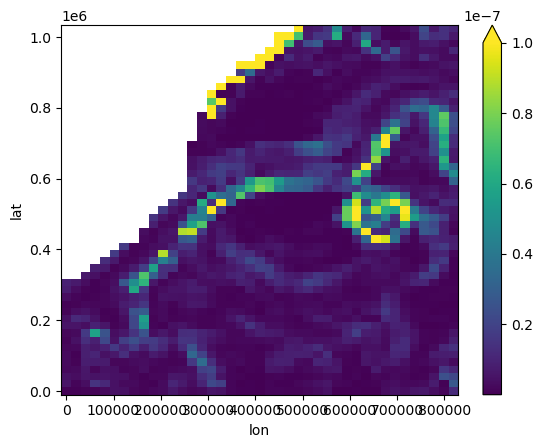

In [53]:
Ekterp.isel(time=0).plot(vmax=1e-7)

In [51]:
PEk = xrft.isotropic_power_spectrum(Ekterp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.), dim=['lat','lon'],
                                    window='hann', window_correction=True,
                                    truncate=True
                                   )
Pbf = xrft.isotropic_power_spectrum(bfterp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.), dim=['lat','lon'],
                                    window='hann', window_correction=True,
                                    truncate=True
                                   )
Pwb = xrft.isotropic_power_spectrum(wbterp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.), dim=['lat','lon'],
                                    window='hann', window_correction=True,
                                    truncate=True
                                   )

CEk = (xrft.isotropic_cross_spectrum(Psix_Ekterp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.).transpose('time','lat','lon'),
                                    By_terp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.), dim=['lat','lon'],
                                    # detrend='constant',
                                    window='hann', window_correction=True,
                                     nfactor=2,
                                    truncate=True
                                   )
       - xrft.isotropic_cross_spectrum(Psiy_Ekterp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.).transpose('time','lat','lon'),
                                    Bx_terp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.), dim=['lat','lon'],
                                    # detrend='constant',
                                    window='hann', window_correction=True,
                                       nfactor=2,
                                    truncate=True
                                   )
      )
Cbf = (xrft.isotropic_cross_spectrum(Psix_bfterp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.).transpose('time','lat','lon'), 
                                     By_terp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.), dim=['lat','lon'],
                                    # detrend='constant',
                                    window='hann', window_correction=True,
                                     nfactor=2,
                                    truncate=True
                                   )
       - xrft.isotropic_cross_spectrum(Psiy_bfterp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.).transpose('time','lat','lon'),
                                    Bx_terp.sel(lat=slice(None,8e5),
                                               lon=slice(4e5,None)
                                              ).fillna(0.), dim=['lat','lon'],
                                    # detrend='constant',
                                    window='hann', window_correction=True,
                                       nfactor=2,
                                    truncate=True
                                   )
      )
# Cwb = xrft.isotropic_cross_spectrum(np.abs(ws_terp).sel(lat=slice(None,8e5),
#                                                lon=slice(4e5,None)
#                                               ).fillna(0.),
#                                     np.abs(bs_terp).sel(lat=slice(None,8e5),
#                                                lon=slice(4e5,None)
#                                               ).fillna(0.),
#                                     dim=['lat','lon'],
#                                     # detrend='constant',
#                                     window='hann', window_correction=True,
#                                     nfactor=2,
#                                     truncate=True
#                                    )

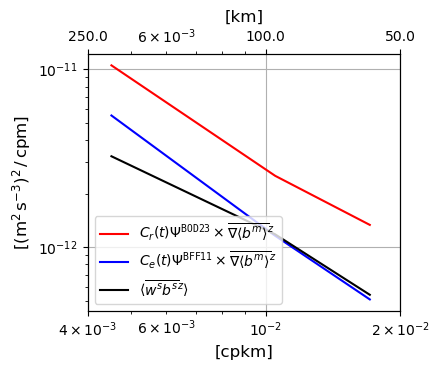

In [100]:
fig, ax = plt.subplots(figsize=(4.5,3.8))
ax2 = ax.twiny()
fig.set_tight_layout(True)

ax.plot(PEk.freq_r*1e3, PEk.mean('time'), 'r',
        label=r"$C_r(t)\Psi^{\tt BOD23}\times\overline{\nabla\langle b^m\rangle}^z$")
ax.plot(Pbf.freq_r*1e3, Pbf.mean('time'), 'b',
        label=r"$C_e(t)\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$")
ax.plot(Pwb.freq_r*1e3, Pwb.mean('time'), 'k', 
        label=r"$\langle\overline{w^sb^s}^z\rangle$")
ax2.plot(PEk.freq_r*1e3, PEk.mean('time'), 'r', alpha=0,
        label=r"$C_r(t)\Psi^{\tt BOD23}\times\overline{\nabla\langle b^m\rangle}^z$")

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left', fontsize=10)

ax.grid(True)
ax.set_ylabel(r"[(m$^2\,$s$^{-3}$)$^2\,/\,$cpm]", fontsize=12)
ax.set_xlabel(r"[cpkm]", fontsize=12)

ax2.set_xlabel(r"[km]", fontsize=12)
ax.set_xticks([4e-3, 1e-2, 2e-2])
ax2.set_xticks([4e-3, 1e-2, 2e-2])
ax2.set_xticklabels([2.5e2, 1e2, 5e1])

plt.savefig(op.join(sdir,'Figs/HYCOM50_region%02d_nC%02d_pwrspec.pdf' 
                    % (int(reg[0]),nC)))

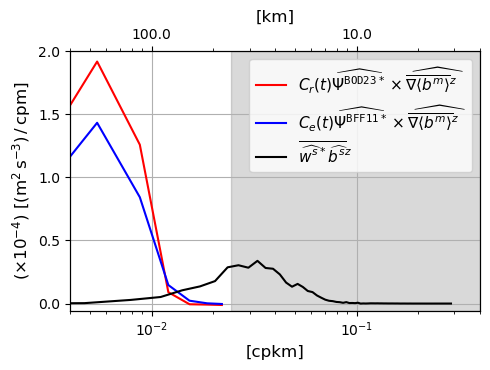

In [112]:
fig, ax = plt.subplots(figsize=(5,3.8))
ax2 = ax.twiny()
fig.set_tight_layout(True)

ax.plot(CEk.freq_r*1e3, (CrEkC[::14]*CEk).real.mean('time')*1e4, 'r',
        label=r"$C_r(t)\widehat{\Psi^{\tt BOD23}}^*\times\widehat{\overline{\nabla\langle b^m\rangle}^z}$")
ax.plot(Cbf.freq_r*1e3, (CeC[::14]*Cbf).real.mean('time')*1e4, 'b',
        label=r"$C_e(t)\widehat{\Psi^{\tt BFF11}}^*\times\widehat{\overline{\nabla\langle b^m\rangle}^z}$")
ax.plot(
        # Cwb.freq_r*1e3, 
        # Cwb.real.mean('time'), 
        CwsbsH.freq_r*1e3,
        CwsbsH.real.mean('time')*1e4,
        'k', 
        label=r"$\overline{\widehat{w^s}^*\widehat{b^s}}^z$")
ax2.plot(CEk.freq_r*1e3, (CrEkC[::14]*CEk).real.mean('time'), 'r', alpha=0,
        # label=r"$C_r(t)\Psi^{\tt Bod}\times\overline{\nabla\langle b^m\rangle}^z$"
        )
ax2.plot(
        # Cwb.freq_r*1e3, 
        # Cwb.real.mean('time'), 
        CwsbsH.freq_r*1e3,
        CwsbsH.real.mean('time')*1e4,
        'k', alpha=0.,
        # label=r"$\overline{\widehat{w^s}^*\widehat{b^s}}^z$"
)

ax.fill_between(np.array([1/(2*np.sqrt(aC.mean()))*1e3, 4e-1]), 
                -.06, 2., 
                color='k', alpha=.15)

ax.set_xscale('log')
ax2.set_xscale('log')
# ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=11)

ax.grid(True)
ax.set_ylabel(r"($\times10^{-4}$) [(m$^2\,$s$^{-3}$)$\,/\,$cpm]", fontsize=12)
ax.set_xlabel(r"[cpkm]", fontsize=12)

ax2.set_xlabel(r"[km]", fontsize=12)
ax.set_xticks([1e-2, 1e-1])
ax2.set_xticks([1e-2, 1e-1])
ax2.set_xticklabels([1e2, 1e1])
ax.set_yticks([0,.5,1.,1.5,2.])
# ax2.set_xticklabels([1e2, 1e1])
ax.set_ylim([-.06,2.])
ax.set_xlim([4e-3,4e-1])
ax2.set_xlim([4e-3,4e-1])

plt.savefig(op.join(sdir,'Figs/HYCOM50_region%02d_nC%02d_crospec.pdf' 
                    % (int(reg[0]),nC)))

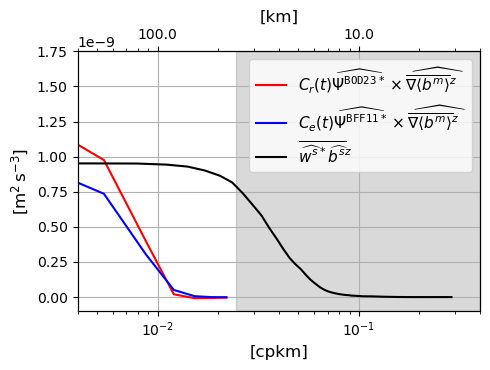

In [52]:
fig, ax = plt.subplots(figsize=(5,3.8))
ax2 = ax.twiny()
fig.set_tight_layout(True)

ax.plot(CEk.freq_r*1e3, 
        ((CrEkC[::14]*CEk).real.mean('time')
         * np.diff(CEk.freq_r)[0])[::-1].cumsum('freq_r')[::-1], 
        'r',
        label=r"$C_r(t)\widehat{\Psi^{\tt BOD23}}^*\times\widehat{\overline{\nabla\langle b^m\rangle}^z}$")
ax.plot(Cbf.freq_r*1e3, 
        ((CeC[::14]*Cbf).real.mean('time')
         * np.diff(Cbf.freq_r)[0])[::-1].cumsum('freq_r')[::-1], 
        'b',
        label=r"$C_e(t)\widehat{\Psi^{\tt BFF11}}^*\times\widehat{\overline{\nabla\langle b^m\rangle}^z}$")
ax.plot(
        # Cwb.freq_r*1e3, 
        # Cwb.real.mean('time'), 
        CwsbsH.freq_r*1e3,
        (CwsbsH.real.mean('time')
         * np.diff(CwsbsH.freq_r)[0])[::-1].cumsum('freq_r')[::-1],
        'k', 
        label=r"$\overline{\widehat{w^s}^*\widehat{b^s}}^z$")
ax2.plot(CEk.freq_r*1e3, 
         ((CrEkC[::14]*CEk).real.mean('time')
         * np.diff(CEk.freq_r)[0])[::-1].cumsum('freq_r')[::-1],
         'r', alpha=0,
        # label=r"$C_r(t)\Psi^{\tt Bod}\times\overline{\nabla\langle b^m\rangle}^z$"
        )
ax2.plot(
        # Cwb.freq_r*1e3, 
        # Cwb.real.mean('time'), 
        CwsbsH.freq_r*1e3,
        (CwsbsH.real.mean('time')
         * np.diff(CwsbsH.freq_r)[0])[::-1].cumsum('freq_r')[::-1],
        'k', alpha=0.,
        # label=r"$\overline{\widehat{w^s}^*\widehat{b^s}}^z$"
)

ax.fill_between(np.array([1/(2*np.sqrt(aC.mean()))*1e3, 4e-1]), 
                -.1e-9,1.75e-9, 
                color='k', alpha=.15)

ax.set_xscale('log')
ax2.set_xscale('log')
# ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=11)

ax.grid(True)
ax.set_ylabel(r"[m$^2\,$s$^{-3}$]", fontsize=12)
ax.set_xlabel(r"[cpkm]", fontsize=12)

ax2.set_xlabel(r"[km]", fontsize=12)
ax.set_xticks([1e-2, 1e-1])
ax2.set_xticks([1e-2, 1e-1])
ax2.set_xticklabels([1e2, 1e1])
ax.set_ylim([-.1e-9,1.75e-9])
ax.set_xlim([4e-3,4e-1])
ax2.set_xlim([4e-3,4e-1])

plt.savefig(op.join(sdir,'Figs/HYCOM50_region%02d_nC%02d_CUMSUMcrospec.pdf' 
                    % (int(reg[0]),nC)))

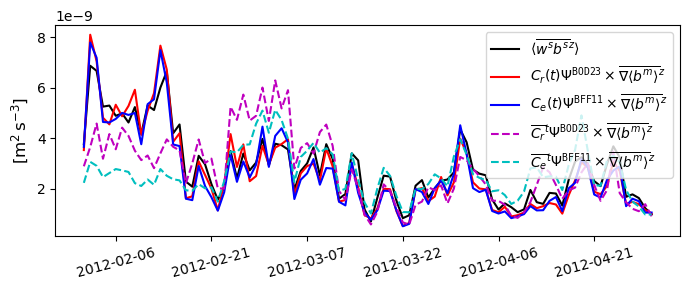

In [41]:
fig, ax = plt.subplots(figsize=(7,3))
fig.set_tight_layout(True)
# ax2 = ax.twinx()

ax.plot(range(90), WsBs.median(['lat','lon'],skipna=True).values, 
        'k', label=r"$\langle\overline{w^sb^s}^z\rangle$"
       )
ax.plot(range(90), cbodEk.median(['lat','lon'],skipna=True).values, 
        'r', 
        label=r"$C_r(t)\Psi^{\tt BOD23}\times\overline{\nabla\langle b^m\rangle}^z$"
       )
ax.plot(range(90), cbff.median(['lat','lon'],skipna=True).values, 
        'b', 
        label=r"$C_e(t)\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$"
       )
ax.plot(range(90), CbodEk.median(['lat','lon'],skipna=True).values, 
        'm--', 
 label=r"$\overline{C_r}^t\Psi^{\tt BOD23}\times\overline{\nabla\langle b^m\rangle}^z$"
       )
ax.plot(range(90), Cbff.median(['lat','lon'],skipna=True).values, 
        'c--', 
 label=r"$\overline{C_e}^t\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$"
       )

ax.set_xticks(np.arange(90)[5::15])
ax.set_xticklabels(time[5::15], rotation=15)
# ax2.yaxis.label.set_color('red')         #setting up Y-axis label color to blue
# ax2.tick_params(axis='y', colors='red')  #setting up Y-axis tick color to black
# ax2.spines['right'].set_color('red')
ax.legend(loc='upper right', fontsize=10)
# ax2.legend(loc='upper right', fontsize=12)
ax.set_ylabel(r"[m$^2\,$s$^{-3}$]", fontsize=12)
# ax2.set_ylabel(r"$C_r(t)$", fontsize=13)
plt.savefig(op.join(sdir,'Figs/HYCOM50_region%02d_nC%02d_TimeSeries.pdf' 
                    % (int(reg[0]),nC)))

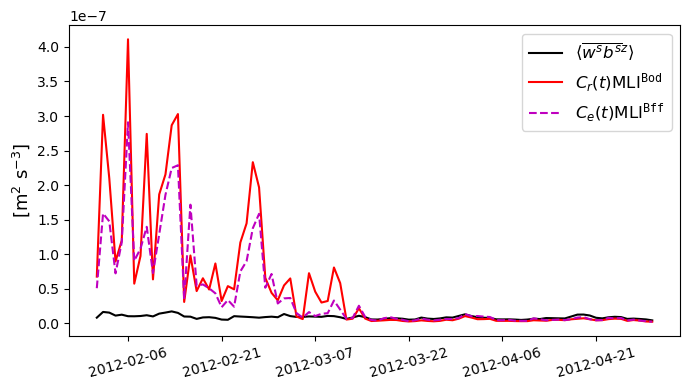

In [39]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
# ax2 = ax.twinx()

ax.plot(range(90), WsBs.mean(['lat','lon'],skipna=True).values, 
        'k', label=r"$\langle\overline{w^sb^s}^z\rangle$")
ax.plot(range(90), CbodEk.mean(['lat','lon'],skipna=True).values, 
        'r', label=r"$C_r(t)$MLI$^{\tt Bod}$")
ax.plot(range(90), Cbff.mean(['lat','lon'],skipna=True).values, 
        'm--', label=r"$C_e(t)$MLI$^{\tt Bff}$")

ax.set_xticks(np.arange(90)[5::15])
ax.set_xticklabels(time[5::15], rotation=15)
# ax2.yaxis.label.set_color('red')         #setting up Y-axis label color to red
# ax2.tick_params(axis='y', colors='red')  #setting up Y-axis tick color to red
# ax2.spines['right'].set_color('red')
ax.legend(loc='upper right', fontsize=12)
# ax2.legend(loc='upper right', fontsize=12)
ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
# ax2.set_ylabel(r"$C_r(t)$", fontsize=13)
plt.savefig(op.join(sdir,'Figs/HYCOM50_region%02d_MeanTimeSeries.pdf' 
                    % int(reg[0])))

/tmp/ipykernel_298131/1167379178.py:4: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im1 = axes[0,0].pcolor(lonC, latC, WsBs.isel(time=0),
/tmp/ipykernel_298131/1167379178.py:8: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im2 = axes[0,1].pcolor(lonC, latC, CbodEk.isel(time=0),
/tmp/ipykernel_298131/1167379178.py:16: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im3 = axes[1,1].pcolor(lonC, latC, Cbff.

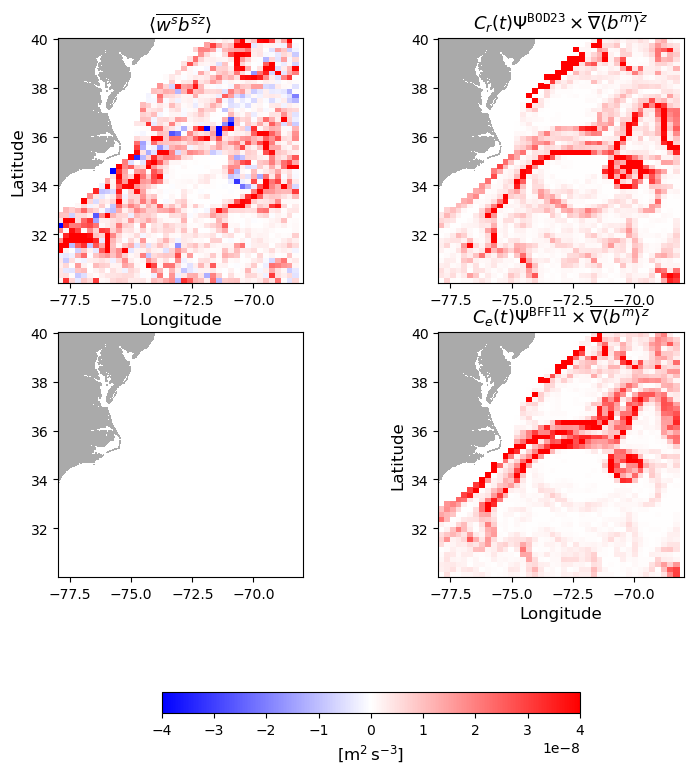

In [54]:
fig, axes = plt.subplots(figsize=(9,10), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im1 = axes[0,0].pcolor(lonC, latC, WsBs.isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-.4e-7, vmax=.4e-7
                      )
im2 = axes[0,1].pcolor(lonC, latC, CbodEk.isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-.4e-7, vmax=.4e-7
                      )
# im2 = axes[1,0].pcolor(lonC, latC, CbodEbl.isel(time=0), 
#                  cmap='bwr', rasterized=True,
#                  vmin=-.6e-7, vmax=.6e-7
#                       )
im3 = axes[1,1].pcolor(lonC, latC, Cbff.isel(time=0), 
                 cmap='bwr', rasterized=True,
                 vmin=-.4e-7, vmax=.4e-7
                      )

axes[0,0].pcolor(dsc_sub.tlon.isel(lat=slice(1,-1),lon=slice(1,-1)),
                 dsc_sub.tlat.isel(lat=slice(1,-1),lon=slice(1,-1)),
                 wet_mask.where(wet_mask==0.).isel(time=0,Z=0,lat=slice(1,-1),
                                                   lon=slice(1,-1)),
                 cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[0,1].pcolor(dsc_sub.tlon.isel(lat=slice(1,-1),lon=slice(1,-1)),
                 dsc_sub.tlat.isel(lat=slice(1,-1),lon=slice(1,-1)),
                 wet_mask.where(wet_mask==0.).isel(time=0,Z=0,lat=slice(1,-1),
                                                   lon=slice(1,-1)),
                 cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[1,0].pcolor(dsc_sub.tlon.isel(lat=slice(1,-1),lon=slice(1,-1)),
                 dsc_sub.tlat.isel(lat=slice(1,-1),lon=slice(1,-1)),
                 wet_mask.where(wet_mask==0.).isel(time=0,Z=0,lat=slice(1,-1),
                                                   lon=slice(1,-1)),
                 cmap='binary', vmin=-1, vmax=2, rasterized=True)
axes[1,1].pcolor(dsc_sub.tlon.isel(lat=slice(1,-1),lon=slice(1,-1)),
                 dsc_sub.tlat.isel(lat=slice(1,-1),lon=slice(1,-1)), 
                 wet_mask.where(wet_mask==0.).isel(time=0,Z=0,lat=slice(1,-1),
                                                   lon=slice(1,-1)),
                 cmap='binary', vmin=-1, vmax=2, rasterized=True)

axes[0,0].set_title(r"$\langle\overline{w^sb^s}^{z}\rangle$", fontsize=13)
axes[0,1].set_title(
r"$C_r(t) \Psi^{\tt BOD23} \times \overline{\nabla\langle b^m\rangle}^z$",
# r"$C_r(t)\frac{\Delta s|f|h_{Ek}H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{(m_*u_*^3 + n_*w_*^3)^{2/3}} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
# axes[1,0].set_title(
# r"$C_r\frac{\Delta s|f|h_{ePBL}H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{(m_*u_*^3 + n_*w_*^3)^{2/3}} \times \overline{\nabla\langle b^m\rangle}^z$", 
#               fontsize=15)
axes[1,1].set_title(
r"$C_e(t) \Psi^{\tt BFF11} \times \overline{\nabla\langle b^m\rangle}^z$",
#r"$C_e(t)\frac{\Delta s}{L_{ML}}\frac{H^2\overline{\nabla\langle b^m\rangle}^z \times {\bf z}}{f} \times \overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,1].set_ylabel(r"Latitude", fontsize=12)
axes[0,0].set_xlabel(r"Longitude", fontsize=12)
axes[1,1].set_xlabel(r"Longitude", fontsize=12)

# fig.subplots_adjust(right=0.86, hspace=0.22, wspace=.18)
# cbaxes1 = fig.add_axes([0.88, 0.35, 0.014, 0.3]) 
cbar1 = fig.colorbar(im1, orientation='horizontal', ax=axes, shrink=.6)
cbar1.set_label(r"[m$^2\,$s$^{-3}$]", fontsize=12)

plt.savefig(op.join(sdir,'Figs/HYCOM50_MLI_region%02d_nC%02d.pdf' 
                    % (int(reg[0]),nC)))

In [95]:
dbod = np.abs(WsBs) - cbodEk
dbff = np.abs(WsBs) - cbff
Dbod = np.abs(WsBs) - CbodEk
Dbff = np.abs(WsBs) - Cbff
dbod.name = 'Ekman'
dbff.name = 'BFF'
Dbod.name = 'Ekman'
Dbff.name = 'BFF'
dbod

<xarray.DataArray 'Ekman' (time: 90, lat: 51, lon: 41)>
dask.array<sub, shape=(90, 51, 41), dtype=float64, chunksize=(1, 6, 7), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6.5 18.5 30.5 42.5 54.5 ... 570.5 582.5 594.5 606.5
  * lon      (lon) float64 6.5 18.5 30.5 42.5 54.5 ... 450.5 462.5 474.5 486.5
Dimensions without coordinates: time

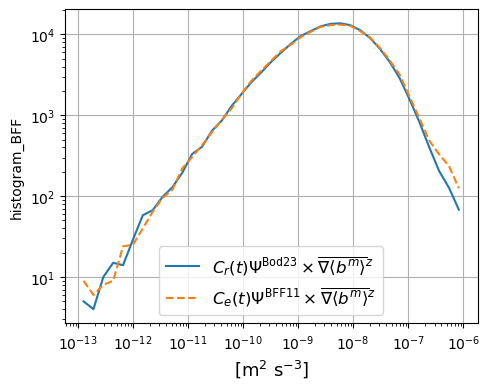

In [115]:
fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)

xhist(np.abs(dbod).chunk({'time':1}), 
      bins=[np.logspace(-13,-6,40)
           ]
     ).plot(ax=ax, 
        label=r"$C_r(t)\Psi^{\tt Bod23}\times\overline{\nabla\langle b^m\rangle}^z$")

xhist(np.abs(dbff).chunk({'time':1}), 
      bins=[np.logspace(-13,-6,40)
           ]
     ).plot(ax=ax, ls='--',
        label=r"$C_e(t)\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$")

# ax.set_xlim([0,None])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='lower center', fontsize=12)
ax.grid(True)
plt.savefig(op.join(sdir,'Figs/HYCOM50-dwb-1Dhist_region%02d.pdf' 
                    % int(reg[0])))

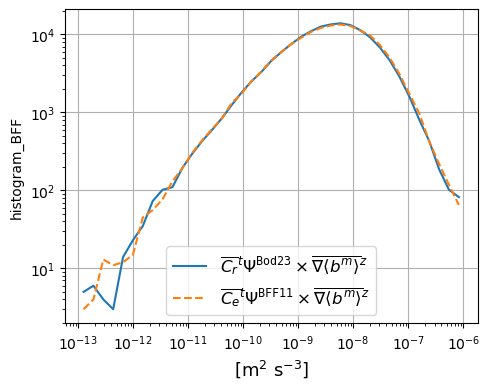

In [114]:
fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)

xhist(np.abs(Dbod).chunk({'time':1}), 
      bins=[np.logspace(-13,-6,40)
           ]
     ).plot(ax=ax, 
    label=r"$\overline{C_r}^t\Psi^{\tt Bod23}\times\overline{\nabla\langle b^m\rangle}^z$")

xhist(np.abs(Dbff).chunk({'time':1}), 
      bins=[np.logspace(-13,-6,40)
           ]
     ).plot(ax=ax, ls='--',
    label=r"$\overline{C_e}^t\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$")

# ax.set_xlim([0,None])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='lower center', fontsize=12)
ax.grid(True)
plt.savefig(op.join(sdir,'Figs/HYCOM50-Dwb-1Dhist_region%02d.pdf' 
                    % int(reg[0])))

In [106]:
xhist_bodEk = xhist(cbodEk.chunk({'time':1}), 
      WsBs.chunk({'time':1}),
      bins=[np.logspace(-11,-6,32), 
            np.concatenate((-np.logspace(-6,-11,32),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-6,32)))))
           ]
     ).compute()
xhist_bff = xhist(cbff.chunk({'time':1}), 
      WsBs.chunk({'time':1}),
      bins=[np.logspace(-11,-6,32), 
            np.concatenate((-np.logspace(-6,-11,32),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-6,32)))))
           ]
     ).compute()
xhist_MLI = xhist(cbff.chunk({'time':1}), 
                  cbodEk.chunk({'time':1}), 
      bins=[np.logspace(-11,-6,32), 
            np.logspace(-11,-6,32)
           ]
     ).compute()

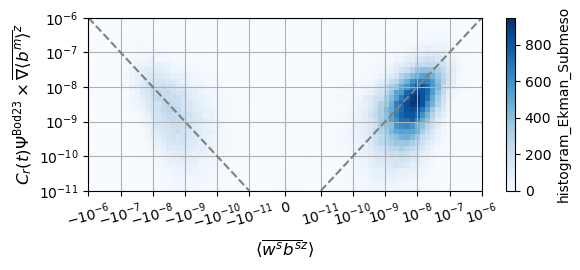

In [137]:
fig, ax = plt.subplots(figsize=(6,2.8))
fig.set_tight_layout(True)

xhist_bodEk.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-11,1e-6), np.linspace(1e-11,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-11), np.linspace(1e-6,1e-11), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-11)
ax.set_yscale('log')
ax.set_ylim([1e-11,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=12)
ax.set_ylabel(
    r"$C_r(t)\Psi^{\tt Bod23}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=12)

ax.grid(True)
ax.set_yticks([1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticks([-1e-6,-1e-7,-1e-8,-1e-9,-1e-10,-1e-11,
               0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticklabels([r"$-10^{-6}$",r"$-10^{-7}$",r"$-10^{-8}$",
                    r"$-10^{-9}$",r"$-10^{-10}$",r"$-10^{-11}$",
                    0,r"$10^{-11}$",r"$10^{-10}$",r"$10^{-9}$",
                    r"$10^{-8}$",r"$10^{-7}$",r"$10^{-6}$"], 
                   rotation=15)
# ax.set_aspect('equal')

plt.savefig(op.join(sdir,
                'Figs/HYCOM50-wb_medianCrEk-hist_region%02d_nC%02d.pdf' 
                    % (int(reg[0]),nC)))

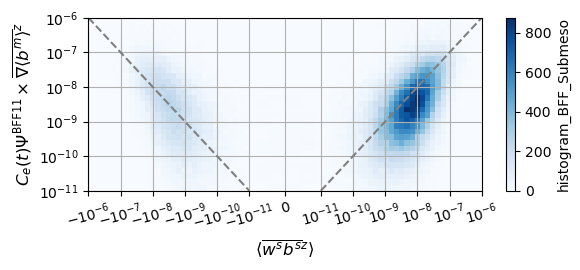

In [136]:
fig, ax = plt.subplots(figsize=(6,2.8))
fig.set_tight_layout(True)

xhist_bff.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-11,1e-6), np.linspace(1e-11,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-11), np.linspace(1e-6,1e-11), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-11)
ax.set_yscale('log')
ax.set_ylim([1e-11,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=12)
ax.set_ylabel(
    r"$C_e(t)\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=12)

ax.grid(True)
ax.set_yticks([1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticks([-1e-6,-1e-7,-1e-8,-1e-9,-1e-10,-1e-11,
               0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticklabels([r"$-10^{-6}$",r"$-10^{-7}$",r"$-10^{-8}$",
                    r"$-10^{-9}$",r"$-10^{-10}$",r"$-10^{-11}$",
                    0,r"$10^{-11}$",r"$10^{-10}$",r"$10^{-9}$",
                    r"$10^{-8}$",r"$10^{-7}$",r"$10^{-6}$"], 
                   rotation=15)
# ax.set_aspect('equal')

plt.savefig(op.join(sdir,
                'Figs/HYCOM50-wb_medianCe-hist_region%02d_nC%02d.pdf' 
                    % (int(reg[0]),nC)))

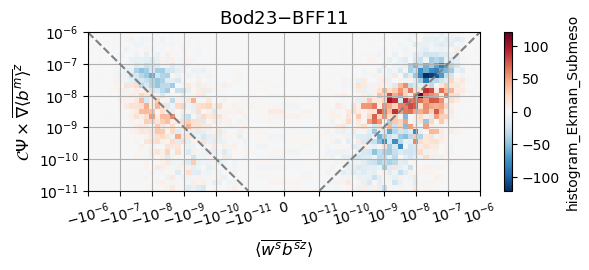

In [138]:
fig, ax = plt.subplots(figsize=(6,2.8))
fig.set_tight_layout(True)

(xhist_bodEk-xhist_bff.data).plot(ax=ax, cmap='RdBu_r')

ax.plot(np.linspace(1e-11,1e-6), np.linspace(1e-11,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-11), np.linspace(1e-6,1e-11), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-11)
ax.set_yscale('log')
ax.set_ylim([1e-11,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=12)
ax.set_ylabel(r"$\mathcal{C}\Psi\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=12)
ax.set_title(r"Bod23$-$BFF11", fontsize=13)

ax.grid(True)
ax.set_yticks([1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticks([-1e-6,-1e-7,-1e-8,-1e-9,-1e-10,-1e-11,
               0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticklabels([r"$-10^{-6}$",r"$-10^{-7}$",r"$-10^{-8}$",
                    r"$-10^{-9}$",r"$-10^{-10}$",r"$-10^{-11}$",
                    0,r"$10^{-11}$",r"$10^{-10}$",r"$10^{-9}$",
                    r"$10^{-8}$",r"$10^{-7}$",r"$10^{-6}$"], 
                   rotation=15)
# ax.set_aspect('equal')

plt.savefig(op.join(sdir,'Figs/HYCOM50-wb_DIFF-hist_region%02d_nC%02d.pdf' 
                    % (int(reg[0]),nC)))

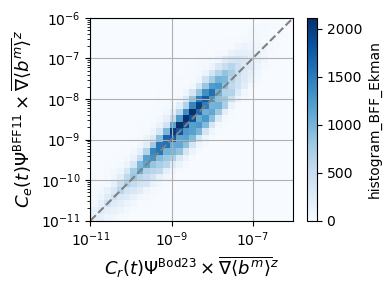

In [109]:
fig, ax = plt.subplots(figsize=(4,3))
fig.set_tight_layout(True)

xhist_MLI.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-11,1e-6), np.linspace(1e-11,1e-6), c='grey', ls='--')
# ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-11,1e-6])
ax.set_xlim([1e-11,1e-6])
ax.set_xlabel(r"$C_r(t)\Psi^{\tt Bod23}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)
ax.set_ylabel(r"$C_e(t)\Psi^{\tt BFF11}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

ax.grid(True)
ax.set_aspect('equal')

plt.savefig(op.join(sdir,'Figs/HYCOM50-wb_MLI-hist_region%02d_nC%02d.pdf' 
                    % (int(reg[0]),nC)))

In [50]:
xhist_bodEk = xhist(CbodEk.chunk({'time':1}), 
      WsBs.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
xhist_bff = xhist(Cbff.chunk({'time':1}), 
      WsBs.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()

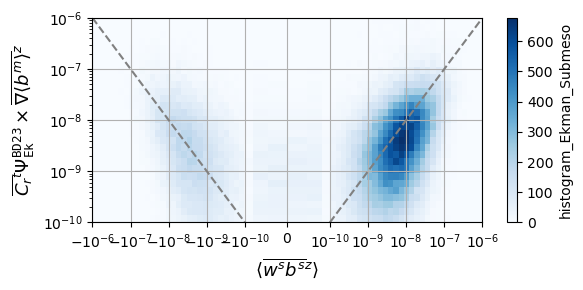

In [51]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist_bodEk.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=13)
ax.set_ylabel(r"$\overline{C_r}^t\Psi^{\tt BD23}_{\tt Ek}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

ax.grid(True)
# ax.set_aspect('equal')

plt.savefig(op.join(sdir,'Figs/HYCOM50-wb_medianCrCEk-hist_region%02d_nC%02d.pdf' 
                    % (int(reg[0]),nC)))

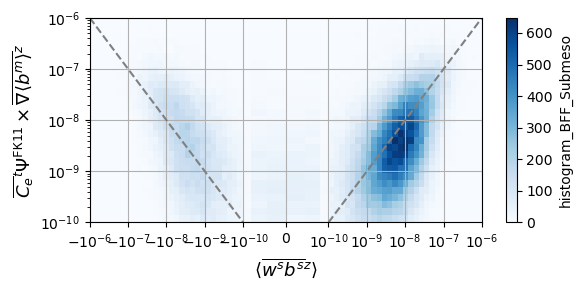

In [52]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist_bff.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\overline{w^sb^s}^z\rangle$", fontsize=13)
ax.set_ylabel(r"$\overline{C_e}^t\Psi^{\tt FK11}\times\overline{\nabla\langle b^m\rangle}^z$", 
              fontsize=13)

ax.grid(True)
# ax.set_aspect('equal')

plt.savefig(op.join(sdir,'Figs/HYCOM50-wb_medianCeC-hist_region%02d_nC%02d.pdf' 
                    % (int(reg[0]),nC)))

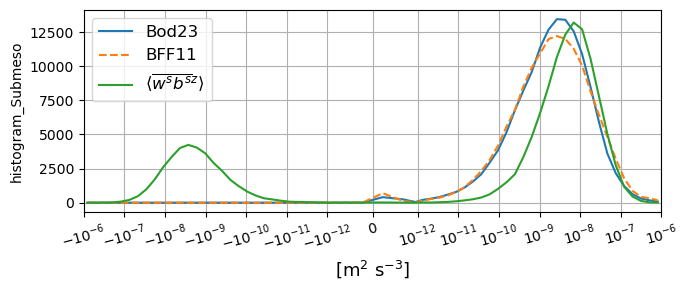

In [128]:
fig, ax = plt.subplots(figsize=(7,3))
fig.set_tight_layout(True)

xhist(cbodEk.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-12,30),
                            np.concatenate((np.linspace(-9e-13,9e-13,5),
                                            np.logspace(-12,-6,30)))))
           ]
     ).plot(ax=ax, label=r"Bod23")
# xhist(CbodEbl.chunk({'time':1}), 
#       bins=[np.concatenate((-np.logspace(-6,-11,30),
#                             np.concatenate((np.linspace(-9e-12,9e-12,5),
#                                             np.logspace(-11,-6,30)))))
#            ]
#      ).plot(ax=ax, label=r"Bodner (ePBL)", ls='--')
xhist(cbff.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-12,30),
                            np.concatenate((np.linspace(-9e-13,9e-13,5),
                                            np.logspace(-12,-6,30)))))
           ]
     ).plot(ax=ax, label=r"BFF11", ls='--')
xhist(WsBs.chunk({'time':1}), 
      bins=[np.concatenate((-np.logspace(-6,-12,30),
                            np.concatenate((np.linspace(-9e-13,9e-13,5),
                                            np.logspace(-12,-6,30)))))
           ]
     ).plot(ax=ax, label=r"$\langle\overline{w^sb^s}^z\rangle$")
ax.set_xscale('symlog', linthresh=1e-12)
ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True)
ax.set_xlim([-1e-6,1e-6])
ax.set_xticks([-1e-6,-1e-7,-1e-8,-1e-9,-1e-10,-1e-11,-1e-12,
               0,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
ax.set_xticklabels([r"$-10^{-6}$",r"$-10^{-7}$",r"$-10^{-8}$",
                    r"$-10^{-9}$",r"$-10^{-10}$",r"$-10^{-11}$",r"$-10^{-12}$",
                    0,r"$10^{-12}$",r"$10^{-11}$",r"$10^{-10}$",r"$10^{-9}$",
                    r"$10^{-8}$",r"$10^{-7}$",r"$10^{-6}$"], 
                   rotation=15)
plt.savefig(op.join(sdir,'Figs/HYCOM50-wb-1Dhist_region%02d_nC%02d.pdf' 
                    % (int(reg[0]),nC)))

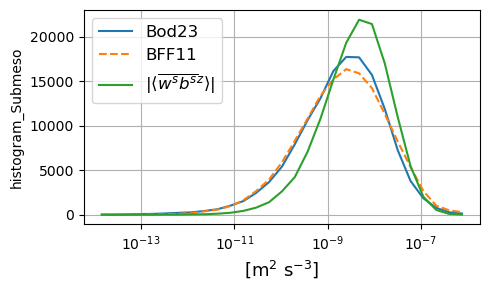

In [127]:
fig, ax = plt.subplots(figsize=(5,3))
fig.set_tight_layout(True)

xhist(cbodEk.chunk({'time':1}), 
      bins=[np.logspace(-14,-6,30)
           ]
     ).plot(ax=ax, label=r"Bod23")
# xhist(CbodEbl.chunk({'time':1}), 
#       bins=[np.concatenate((-np.logspace(-6,-11,30),
#                             np.concatenate((np.linspace(-9e-12,9e-12,5),
#                                             np.logspace(-11,-6,30)))))
#            ]
#      ).plot(ax=ax, label=r"Bodner (ePBL)", ls='--')
xhist(cbff.chunk({'time':1}), 
      bins=[np.logspace(-14,-6,30)
           ]
     ).plot(ax=ax, ls='--', label=r"BFF11")
xhist(np.abs(WsBs).chunk({'time':1}), 
      bins=[np.logspace(-14,-6,30)
           ]
     ).plot(ax=ax, label=r"$|\langle\overline{w^sb^s}^z\rangle|$")
# ax.set_xlim([0,None])
ax.set_xscale('log')
ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True)
plt.savefig(op.join(sdir,'Figs/HYCOM50-wb-1Dhist_region%02d.pdf' 
                    % int(reg[0])))